In [1]:
import numpy as np
import pandas as pd
from torch import nn
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm
from scipy.signal import stft
from scipy.stats import kurtosis
from torchsummary import summary
from tabulate import tabulate

/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
TRAIN_BEARINGS = {
    1: [
        '1_1',
        '1_2',
    ],
    2: [
        '2_1',
        '2_2',
    ],
    3: [
        '3_1',
        '3_2',
    ]
}

TEST_BEARINGS = {
    1: [
        '1_3',
        '1_4',
        '1_5',
        '1_6',
        '1_7',
    ],
    2: [
        '2_3',
        '2_4',
        '2_5',
        '2_6',
        '2_7',
    ],
    3: [
        '3_3',
    ]
}

In [3]:
datasets.Dataset('PRONOSTIA').describe()

PRONOSTIA

Description
The IEEE PHM data challenge in 2012 utilized a renowned dataset provided by the FEMTO-ST Institute. The dataset originated from experiments conducted on a laboratory experimental platform known as PRONOSTIA, designed for accelerated degradation testing of bearings under various operating conditions. During these experiments, online health monitoring data including rotating speed, load force, temperature, and vibration were collected.

The dataset considered data from three different loads, encompassing rotating speed and load force variations. A total of 6 run-to-failure bearings were designated for building prognostic models, while an additional 11 bearings were allocated for testing purposes.

One notable characteristic of the challenge datasets was the relatively small amount of training data available, coupled with a high variability in experiment durations ranging from 1 to 7 hours. This variability posed a significant challenge in accurately estimating prog

In [4]:
dataset = datasets.Dataset('PRONOSTIA')
tasks = dataset['rul']
df = tasks.load()

Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for prognosis and health management datasets." SoftwareX 29 (2025): 102039.



Reading Bearing3_3: 100%|██████████| 13959/13959 [00:32<00:00, 425.31it/s]
INFO:root:Read in 53.115660667419434 seconds


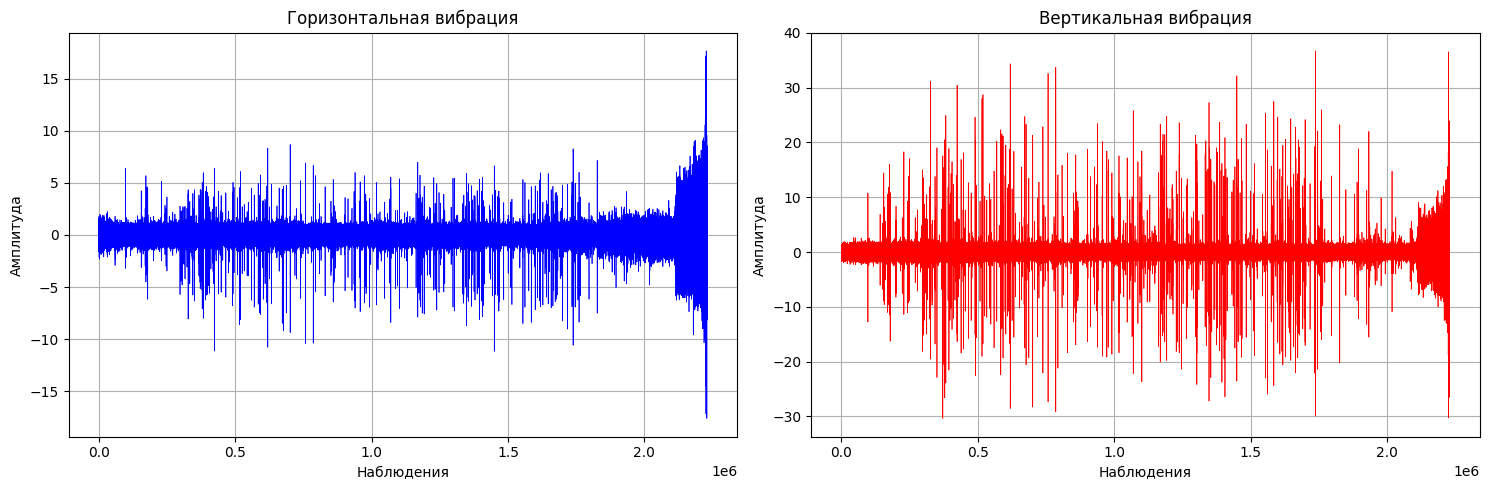

In [9]:
d_1_1 = df[0][df[0]['unit'] == '1_1']
d_1_2 = df[0][df[0]['unit'] == '1_2']
d_2_1 = df[0][df[0]['unit'] == '2_1']
d_2_2 = df[0][df[0]['unit'] == '2_2']
d_3_1 = df[0][df[0]['unit'] == '3_1']
d_3_2 = df[0][df[0]['unit'] == '3_2']

# Create a figure with 1 row and 2 columns (side-by-side plots)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot H_acc (horizontal vibration) on the left
ax1.plot(d_1_2['H_acc'], color='blue', linewidth=0.5)
ax1.set_title('Горизонтальная вибрация')
ax1.set_xlabel('Наблюдения')
ax1.set_ylabel('Амплитуда')
ax1.grid(True)

# Plot V_acc (vertical vibration) on the right
ax2.plot(d_1_2['V_acc'], color='red', linewidth=0.5)
ax2.set_title('Вертикальная вибрация')
ax2.set_xlabel('Наблюдения')
ax2.set_ylabel('Амплитуда')
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

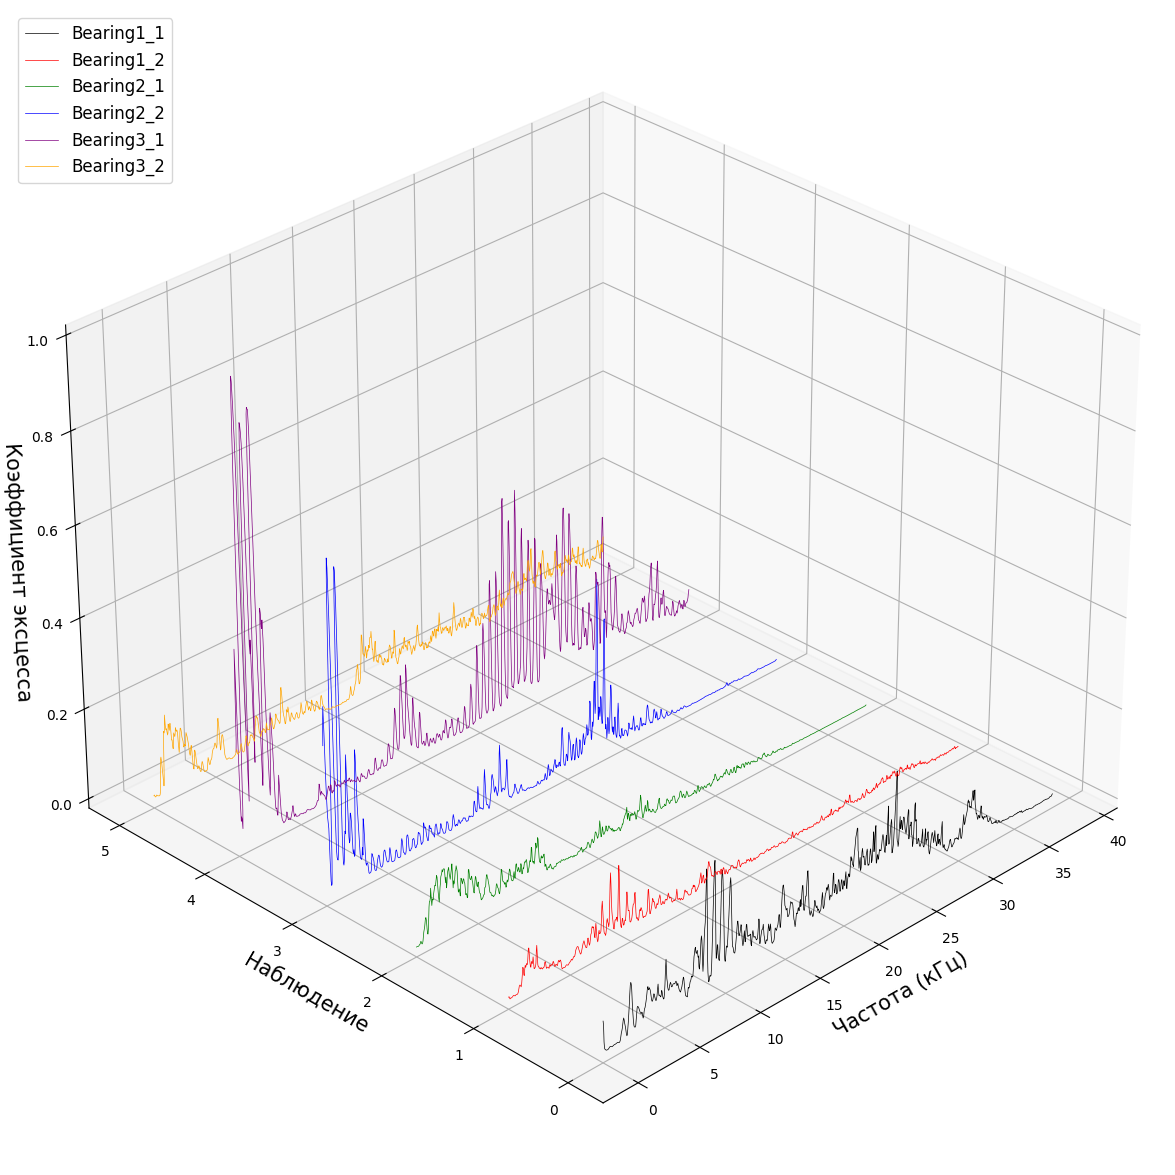

In [45]:
f = []
ffts = []

nperseg = 1024
TRAIN_BEARINGS_LIST = [bearing for bearings_list in TRAIN_BEARINGS.values() for bearing in bearings_list]
LABEL_COLORS = {
    0: 'black',
    1: 'red',
    2: 'green',
    3: 'blue',
    4: 'purple',
    5: 'orange',
}

for bearing in TRAIN_BEARINGS_LIST:
    data = df[0][df[0]['unit'] == bearing]
    vibration_signal = (data['H_acc'] - np.mean(data['H_acc'])) / np.std(data['H_acc'])
    u,v,w = stft(vibration_signal, 25.6 * 1000, nperseg=nperseg,noverlap = 512, window='hann', nfft=2048)
    f.append(u)
    ffts.append(kurtosis(np.abs(w),fisher = False,axis = 1))

f = np.asarray(f)
ffts = np.asarray(ffts)

fftn = (ffts - ffts.min()) / (ffts.max() - ffts.min())

fftn = np.asarray(fftn)


def plot_3d_bearing_kurtosis(f, bearings_list, label_colors):
    n = np.ones_like(f[0])

    fig = plt.figure(figsize = (15.0, 15.0))
    ax = plt.axes(projection = '3d')
    ax.view_init(30,225)
    for i in range(f.shape[0]):
        ax.plot(
            (f[i] * 3) / 1.0e3,
            i * n,
            fftn[i],
            color=label_colors[i],
            linewidth = 0.50,
            label='Bearing' + bearings_list[i],
        )

    ax.legend(loc='upper left', fontsize=12)
    ax.set_xlabel('Частота (кГц)', fontsize=15)
    ax.set_ylabel('Наблюдение', fontsize=15)
    ax.set_zlabel('Коэффициент эксцесса', fontsize=15)
    plt.show()

plot_3d_bearing_kurtosis(
    f=f,
    bearings_list=TRAIN_BEARINGS_LIST,
    label_colors=LABEL_COLORS
)

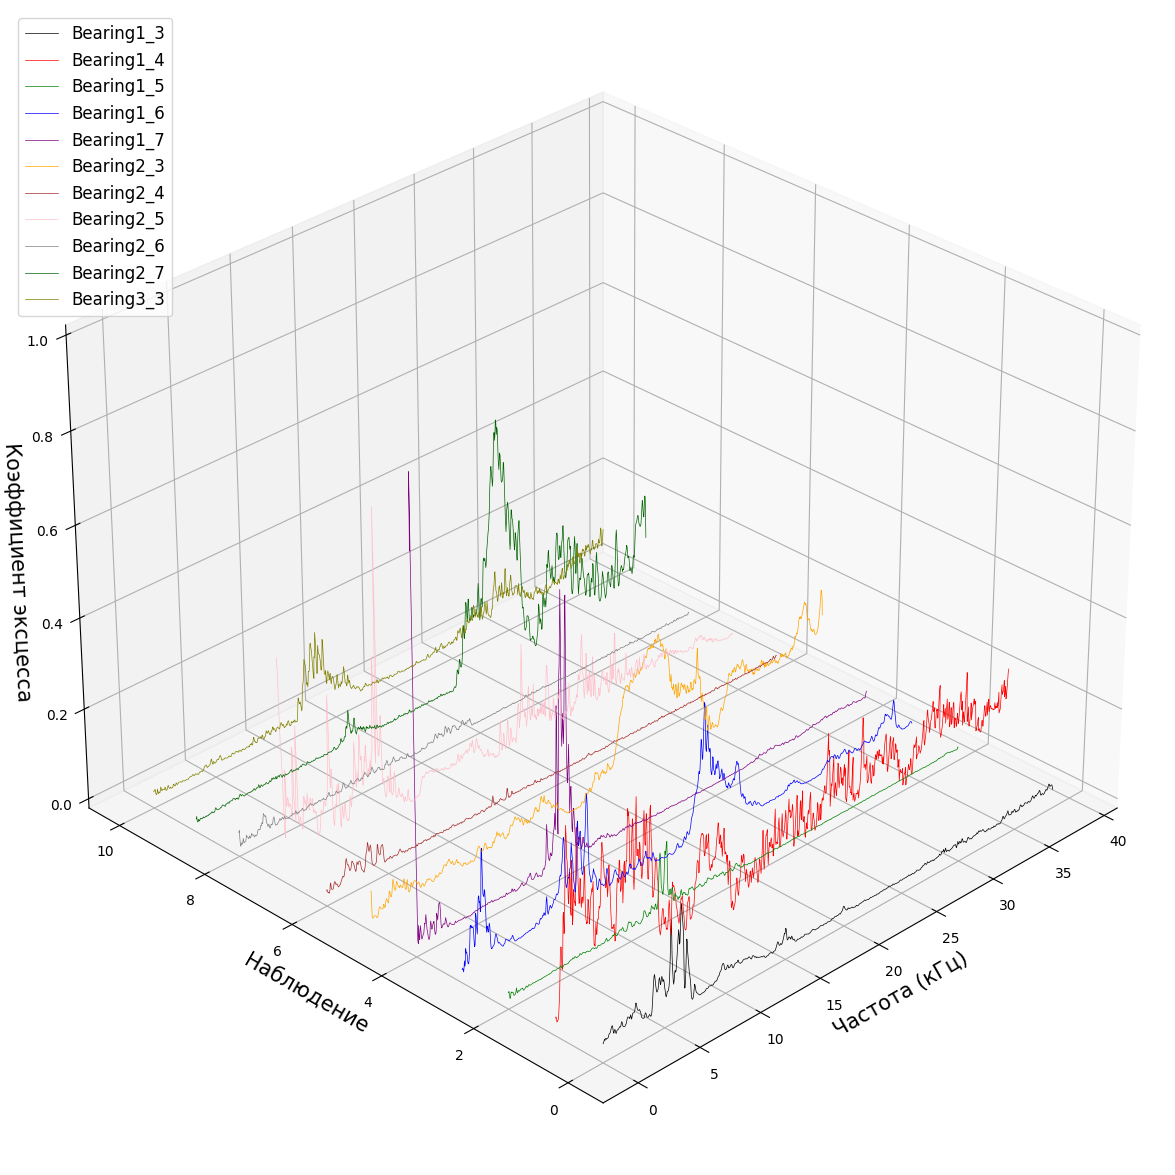

In [47]:
f = []
ffts = []

nperseg = 1024
TEST_BEARINGS_LIST = [bearing for bearings_list in TEST_BEARINGS.values() for bearing in bearings_list]
LABEL_COLORS = {
    0: 'black',
    1: 'red',
    2: 'green',
    3: 'blue',
    4: 'purple',
    5: 'orange',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'darkgreen',
    10: 'olive',
}

for bearing in TEST_BEARINGS_LIST:
    data = df[1][df[1]['unit'] == bearing]
    vibration_signal = (data['H_acc'] - np.mean(data['H_acc'])) / np.std(data['H_acc'])
    u,v,w = stft(vibration_signal, 25.6 * 1000, nperseg=nperseg,noverlap = 512, window='hann', nfft=2048)
    f.append(u)
    ffts.append(kurtosis(np.abs(w),fisher = False,axis = 1))

f = np.asarray(f)
ffts = np.asarray(ffts)

fftn = (ffts - ffts.min()) / (ffts.max() - ffts.min())

fftn = np.asarray(fftn)

plot_3d_bearing_kurtosis(
    f=f,
    bearings_list=TEST_BEARINGS_LIST,
    label_colors=LABEL_COLORS
)

In [5]:
# train
df[0]['unit'].unique()

array(['1_1', '1_2', '2_1', '2_2', '3_1', '3_2'], dtype=object)

In [6]:
df[0].head(5)

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1


In [7]:
# test
df[1]['unit'].unique()

array(['1_3', '1_4', '1_5', '1_6', '1_7', '2_3', '2_4', '2_5', '2_6',
       '2_7', '3_3'], dtype=object)

In [8]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]['unit']

0          1_1
1          1_1
2          1_1
3          1_1
4          1_1
          ... 
7175675    1_1
7175676    1_1
7175677    1_1
7175678    1_1
7175679    1_1
Name: unit, Length: 7175680, dtype: object

In [9]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1
...,...,...,...,...
7175675,0,2.129,-3.353,1_1
7175676,0,-2.299,-2.868,1_1
7175677,0,-1.844,-5.507,1_1
7175678,0,2.146,-3.578,1_1


In [10]:
df[1][df[1]['unit'].isin(TEST_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,23749,0.044,0.092,1_3
1,23749,0.432,-0.025,1_3
2,23749,0.008,-0.104,1_3
3,23749,-0.264,0.056,1_3
4,23749,-0.195,0.074,1_3
...,...,...,...,...
3845115,7570,-0.013,0.481,1_7
3845116,7570,-0.272,0.191,1_7
3845117,7570,0.466,0.250,1_7
3845118,7570,-0.582,0.001,1_7


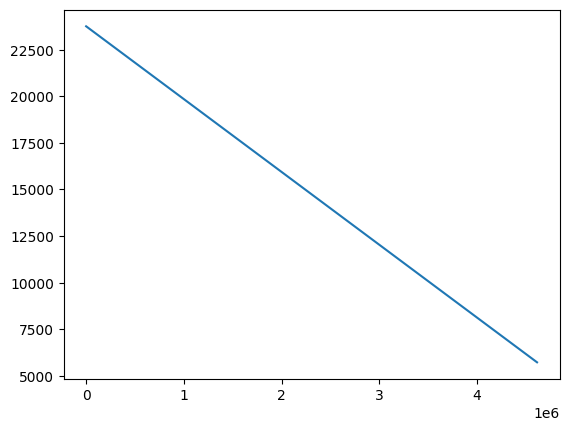

In [11]:
plt.plot(df[1][df[1]['unit'] == '1_3']['rul'])

In [5]:
class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=2560, step=2560 // 2):
        self.windows = []
        self.ruls = []
        
        # Create sequences
        for _, group in df.groupby('unit'):
            h_acc =  group['H_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
            v_acc =  group['V_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )

            rul = group['rul'].transform(lambda x: x / x.max())

            for i in range(0, len(group) - window_size, step):

                self.windows.append(np.stack([
                    h_acc[i:i+window_size], 
                    v_acc[i:i+window_size]
                ], axis=1))
                self.ruls.append(rul.values[i+window_size-1])

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), torch.FloatTensor([self.ruls[idx]])
    
train_dataset = BearingDataset(
    # [b for state in TRAIN_BEARINGS for b in TRAIN_BEARINGS[state]]
    df=df[0][df[0]['unit'].isin(['1_1'])],
)

test_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_7'],
)

val_dataset = BearingDataset(
    df=df[0][df[0]['unit'] == '1_2'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
len(train_dataset)

5604

In [19]:
class BearingCNN(torch.nn.Module):
    def __init__(self):
        super(BearingCNN, self).__init__()
        
        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=5, stride=1, padding=2),  # [32, 16, 2560]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),                  # [32, 16, 1280]
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),  # [32, 32, 1280]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),                  # [32, 32, 640]
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),  # [32, 64, 640]
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)                                 # [32, 64, 1]
        )
        
        # Regressor
        self.regressor = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.features(x)       # [32, 64, 1]
        x = x.squeeze(-1)          # [32, 64]
        x = self.regressor(x)      # [32, 1]
        return x

model = BearingCNN()
# model.load_state_dict(torch.load('last_r2_model.pth', weights_only=True))

In [20]:
# def model_summary_table(model, input_shape):
#     # Get summary as a string
#     summary_str = []
#     def hook(module, input, output):
#         summary_str.append([
#             module.__class__.__name__,
#             list(input[0].shape) if isinstance(input, tuple) else input.shape,
#             list(output.shape),
#             sum(p.numel() for p in module.parameters())
#         ])
    
#     # Register hooks
#     hooks = []
#     for layer in model.children():
#         hooks.append(layer.register_forward_hook(hook))
    
#     # Dummy forward pass
#     dummy_input = torch.randn(input_shape)
#     model(dummy_input)
    
#     # Remove hooks
#     for hook in hooks:
#         hook.remove()
    
#     # Print table
#     headers = ["Layer (type)", "Input Shape", "Output Shape", "Param #"]
#     print(tabulate(summary_str, headers=headers, tablefmt="grid"))

# summary(model, input_size=(2560, 2), batch_size=32, device='cpu')

In [22]:
class LogCoshLoss(nn.Module):
    def forward(self, y_pred, y_true):
        return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def weighted_mse_loss(y_pred, y_true):
    alpha=2.0
    error = y_pred - y_true
    weights = torch.where(error < 0, alpha, 1.0)  # Heavier penalty for underestimating RUL
    return torch.mean(weights * (error ** 2))

def r2_score_loss(y_pred, y_true):
    # Calculate R² (Coefficient of Determination)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))  # Avoid division by zero
    return -r2  # Minimize this (equivalent to maximizing R²)

def hybrid_r2_mse_loss(y_pred, y_true,):
    # alpha=0.5
    alpha = 0.3
    mse = torch.mean((y_pred - y_true) ** 2)
    r2 = r2_score_loss(y_pred, y_true)  # Returns -R²
    return alpha * mse + (1 - alpha) * r2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = hybrid_r2_mse_loss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs,
):
    train_r2 = []
    train_mae = []
    train_mse = []
    train_rmse = []
    train_loss = []

    val_r2 = []
    val_mae = []
    val_mse = []
    val_rmse = []
    val_loss = []

    best_r2 = -float('inf')

    for epoch in range(epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_targets = []

        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)

            epoch_train_preds.append(y_pred)
            epoch_train_targets.append(y_batch)

            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_preds = torch.cat(epoch_train_preds).cpu().detach().numpy()
        train_targets = torch.cat(epoch_train_targets).cpu().detach().numpy()
        
        epoch_train_r2 = r2_score(train_targets, train_preds)
        epoch_train_mae = mean_absolute_error(train_targets, train_preds)
        epoch_train_mse = mean_squared_error(train_targets, train_preds)
        epoch_train_rmse = np.sqrt(epoch_train_mse)
        epoch_train_loss = epoch_train_loss/len(train_loader)
        
        train_r2.append(epoch_train_r2)
        train_mae.append(epoch_train_mae)
        train_mse.append(epoch_train_mse)
        train_rmse.append(epoch_train_rmse)
        train_loss.append(epoch_train_loss)
    
        print(
            f'Epoch {epoch + 1}: Train Loss {epoch_train_loss:.4f}, '
                + f'Train R2 = {epoch_train_r2:.3f}, '
                + f'Train RMSE = {epoch_train_rmse:.3f}, '
                + f'Train MSE = {epoch_train_mse:.3f}, '
                + f'Train MAE = {epoch_train_mae:.3f}'
        )


        model.eval()

        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_targets = []

        with torch.no_grad():
            for X_val, y_val in tqdm(val_loader, desc=f'Epoch {epoch + 1} Val'):
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred = model(X_val)

                epoch_val_preds.append(y_pred)
                epoch_val_targets.append(y_val)
                
                epoch_val_loss += criterion(y_pred, y_val).item()

        val_preds = torch.cat(epoch_val_preds).cpu().detach().numpy()
        val_targets = torch.cat(epoch_val_targets).cpu().detach().numpy()
        
        epoch_val_r2 = r2_score(val_targets, val_preds)
        epoch_val_mae = mean_absolute_error(val_targets, val_preds)
        epoch_val_mse = mean_squared_error(val_targets, val_preds)
        epoch_val_rmse = np.sqrt(epoch_val_mse)
        epoch_val_loss = epoch_val_loss/len(val_loader)
        # scheduler.step(epoch_val_loss)
        
        val_r2.append(epoch_val_r2)
        val_mae.append(epoch_val_mae)
        val_mse.append(epoch_val_mse)
        val_rmse.append(epoch_val_rmse)
        val_loss.append(epoch_val_loss)

        if val_r2[-1] > best_r2:
            best_r2 = val_r2[-1]
            torch.save(model.state_dict(), 'best_r2_model.pth')

        print(
            f'Epoch {epoch + 1}: Val Loss {epoch_val_loss:.4f}, '
                + f'Val R2 = {epoch_val_r2:.3f}, '
                + f'Val RMSE = {epoch_val_rmse:.3f}, '
                + f'Val MSE = {epoch_val_mse:.3f}, '
                + f'Val MAE = {epoch_val_mae:.3f}'
        ) 

    torch.save(model.state_dict(), 'last_r2_model.pth')

    return {
        'train_loss': train_loss,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'val_loss': val_loss,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
    }

In [23]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 100)

train_results

100%|██████████| 176/176 [00:00<00:00, 245.91it/s]


Epoch 1: Train Loss 36011.7048, Train R2 = -0.684, Train RMSE = 0.375, Train MSE = 0.140, Train MAE = 0.215


Epoch 1 Val: 100%|██████████| 55/55 [00:00<00:00, 428.80it/s]


Epoch 1: Val Loss 7776.5898, Val R2 = -2.797, Val RMSE = 0.562, Val MSE = 0.316, Val MAE = 0.483


100%|██████████| 176/176 [00:00<00:00, 251.77it/s]


Epoch 2: Train Loss 23205.2139, Train R2 = 0.044, Train RMSE = 0.282, Train MSE = 0.080, Train MAE = 0.165


Epoch 2 Val: 100%|██████████| 55/55 [00:00<00:00, 480.09it/s]


Epoch 2: Val Loss 7383.1636, Val R2 = -2.597, Val RMSE = 0.547, Val MSE = 0.299, Val MAE = 0.468


100%|██████████| 176/176 [00:00<00:00, 269.63it/s]


Epoch 3: Train Loss 56501.8831, Train R2 = -1.464, Train RMSE = 0.453, Train MSE = 0.205, Train MAE = 0.321


Epoch 3 Val: 100%|██████████| 55/55 [00:00<00:00, 553.07it/s]


Epoch 3: Val Loss 4354.8521, Val R2 = -1.125, Val RMSE = 0.420, Val MSE = 0.177, Val MAE = 0.339


100%|██████████| 176/176 [00:00<00:00, 272.31it/s]


Epoch 4: Train Loss 42956.1645, Train R2 = 0.033, Train RMSE = 0.284, Train MSE = 0.081, Train MAE = 0.220


Epoch 4 Val: 100%|██████████| 55/55 [00:00<00:00, 529.15it/s]


Epoch 4: Val Loss 3775.5281, Val R2 = -0.641, Val RMSE = 0.369, Val MSE = 0.136, Val MAE = 0.304


100%|██████████| 176/176 [00:00<00:00, 251.56it/s]


Epoch 5: Train Loss 41013.0151, Train R2 = -0.917, Train RMSE = 0.400, Train MSE = 0.160, Train MAE = 0.308


Epoch 5 Val: 100%|██████████| 55/55 [00:00<00:00, 528.20it/s]


Epoch 5: Val Loss 3633.0287, Val R2 = -0.760, Val RMSE = 0.383, Val MSE = 0.146, Val MAE = 0.309


100%|██████████| 176/176 [00:00<00:00, 257.73it/s]


Epoch 6: Train Loss 20748.0629, Train R2 = 0.041, Train RMSE = 0.283, Train MSE = 0.080, Train MAE = 0.208


Epoch 6 Val: 100%|██████████| 55/55 [00:00<00:00, 561.17it/s]


Epoch 6: Val Loss 3434.4955, Val R2 = -0.666, Val RMSE = 0.372, Val MSE = 0.139, Val MAE = 0.300


100%|██████████| 176/176 [00:00<00:00, 270.02it/s]


Epoch 7: Train Loss 18306.9847, Train R2 = 0.155, Train RMSE = 0.265, Train MSE = 0.070, Train MAE = 0.202


Epoch 7 Val: 100%|██████████| 55/55 [00:00<00:00, 566.32it/s]


Epoch 7: Val Loss 2931.1841, Val R2 = -0.397, Val RMSE = 0.341, Val MSE = 0.116, Val MAE = 0.279


100%|██████████| 176/176 [00:00<00:00, 270.90it/s]


Epoch 8: Train Loss 17600.8634, Train R2 = 0.215, Train RMSE = 0.256, Train MSE = 0.065, Train MAE = 0.191


Epoch 8 Val: 100%|██████████| 55/55 [00:00<00:00, 560.99it/s]


Epoch 8: Val Loss 2650.1899, Val R2 = -0.282, Val RMSE = 0.327, Val MSE = 0.107, Val MAE = 0.267


100%|██████████| 176/176 [00:00<00:00, 265.89it/s]


Epoch 9: Train Loss 13344.0630, Train R2 = 0.418, Train RMSE = 0.220, Train MSE = 0.048, Train MAE = 0.173


Epoch 9 Val: 100%|██████████| 55/55 [00:00<00:00, 534.41it/s]


Epoch 9: Val Loss 2645.5496, Val R2 = -0.238, Val RMSE = 0.321, Val MSE = 0.103, Val MAE = 0.265


100%|██████████| 176/176 [00:00<00:00, 268.39it/s]


Epoch 10: Train Loss 15494.6641, Train R2 = 0.335, Train RMSE = 0.235, Train MSE = 0.055, Train MAE = 0.169


Epoch 10 Val: 100%|██████████| 55/55 [00:00<00:00, 494.10it/s]


Epoch 10: Val Loss 2338.9145, Val R2 = -0.128, Val RMSE = 0.306, Val MSE = 0.094, Val MAE = 0.253


100%|██████████| 176/176 [00:00<00:00, 266.81it/s]


Epoch 11: Train Loss 10326.9249, Train R2 = 0.576, Train RMSE = 0.188, Train MSE = 0.035, Train MAE = 0.149


Epoch 11 Val: 100%|██████████| 55/55 [00:00<00:00, 570.80it/s]


Epoch 11: Val Loss 2485.6002, Val R2 = -0.146, Val RMSE = 0.309, Val MSE = 0.095, Val MAE = 0.257


100%|██████████| 176/176 [00:00<00:00, 263.86it/s]


Epoch 12: Train Loss 12990.3200, Train R2 = 0.419, Train RMSE = 0.220, Train MSE = 0.048, Train MAE = 0.151


Epoch 12 Val: 100%|██████████| 55/55 [00:00<00:00, 528.40it/s]


Epoch 12: Val Loss 2057.4913, Val R2 = 0.020, Val RMSE = 0.286, Val MSE = 0.082, Val MAE = 0.240


100%|██████████| 176/176 [00:00<00:00, 258.80it/s]


Epoch 13: Train Loss 6797.0289, Train R2 = 0.697, Train RMSE = 0.159, Train MSE = 0.025, Train MAE = 0.117


Epoch 13 Val: 100%|██████████| 55/55 [00:00<00:00, 525.34it/s]


Epoch 13: Val Loss 2196.5831, Val R2 = -0.011, Val RMSE = 0.290, Val MSE = 0.084, Val MAE = 0.243


100%|██████████| 176/176 [00:00<00:00, 264.49it/s]


Epoch 14: Train Loss 8337.0908, Train R2 = 0.633, Train RMSE = 0.175, Train MSE = 0.031, Train MAE = 0.110


Epoch 14 Val: 100%|██████████| 55/55 [00:00<00:00, 557.16it/s]


Epoch 14: Val Loss 1835.8920, Val R2 = 0.158, Val RMSE = 0.265, Val MSE = 0.070, Val MAE = 0.228


100%|██████████| 176/176 [00:00<00:00, 273.98it/s]


Epoch 15: Train Loss 4878.6763, Train R2 = 0.816, Train RMSE = 0.124, Train MSE = 0.015, Train MAE = 0.090


Epoch 15 Val: 100%|██████████| 55/55 [00:00<00:00, 543.84it/s]


Epoch 15: Val Loss 2031.6402, Val R2 = 0.114, Val RMSE = 0.272, Val MSE = 0.074, Val MAE = 0.232


100%|██████████| 176/176 [00:00<00:00, 265.67it/s]


Epoch 16: Train Loss 8317.5800, Train R2 = 0.662, Train RMSE = 0.168, Train MSE = 0.028, Train MAE = 0.101


Epoch 16 Val: 100%|██████████| 55/55 [00:00<00:00, 518.27it/s]


Epoch 16: Val Loss 1903.8532, Val R2 = 0.165, Val RMSE = 0.264, Val MSE = 0.069, Val MAE = 0.229


100%|██████████| 176/176 [00:00<00:00, 262.02it/s]


Epoch 17: Train Loss 4251.1887, Train R2 = 0.888, Train RMSE = 0.097, Train MSE = 0.009, Train MAE = 0.077


Epoch 17 Val: 100%|██████████| 55/55 [00:00<00:00, 520.95it/s]


Epoch 17: Val Loss 2085.2205, Val R2 = 0.153, Val RMSE = 0.265, Val MSE = 0.070, Val MAE = 0.229


100%|██████████| 176/176 [00:00<00:00, 258.83it/s]


Epoch 18: Train Loss 8508.3287, Train R2 = 0.635, Train RMSE = 0.174, Train MSE = 0.030, Train MAE = 0.106


Epoch 18 Val: 100%|██████████| 55/55 [00:00<00:00, 537.00it/s]


Epoch 18: Val Loss 2050.4944, Val R2 = 0.122, Val RMSE = 0.270, Val MSE = 0.073, Val MAE = 0.233


100%|██████████| 176/176 [00:00<00:00, 268.95it/s]


Epoch 19: Train Loss 2453.3492, Train R2 = 0.916, Train RMSE = 0.084, Train MSE = 0.007, Train MAE = 0.063


Epoch 19 Val: 100%|██████████| 55/55 [00:00<00:00, 513.50it/s]


Epoch 19: Val Loss 2028.6075, Val R2 = 0.199, Val RMSE = 0.258, Val MSE = 0.067, Val MAE = 0.225


100%|██████████| 176/176 [00:00<00:00, 258.94it/s]


Epoch 20: Train Loss 4461.9675, Train R2 = 0.801, Train RMSE = 0.129, Train MSE = 0.017, Train MAE = 0.081


Epoch 20 Val: 100%|██████████| 55/55 [00:00<00:00, 511.81it/s]


Epoch 20: Val Loss 2432.9139, Val R2 = 0.017, Val RMSE = 0.286, Val MSE = 0.082, Val MAE = 0.243


100%|██████████| 176/176 [00:00<00:00, 268.10it/s]


Epoch 21: Train Loss 1464.3632, Train R2 = 0.947, Train RMSE = 0.067, Train MSE = 0.004, Train MAE = 0.050


Epoch 21 Val: 100%|██████████| 55/55 [00:00<00:00, 560.06it/s]


Epoch 21: Val Loss 2304.4779, Val R2 = 0.136, Val RMSE = 0.268, Val MSE = 0.072, Val MAE = 0.230


100%|██████████| 176/176 [00:00<00:00, 270.54it/s]


Epoch 22: Train Loss 2670.1706, Train R2 = 0.893, Train RMSE = 0.094, Train MSE = 0.009, Train MAE = 0.062


Epoch 22 Val: 100%|██████████| 55/55 [00:00<00:00, 560.10it/s]


Epoch 22: Val Loss 3245.2862, Val R2 = -0.279, Val RMSE = 0.326, Val MSE = 0.106, Val MAE = 0.271


100%|██████████| 176/176 [00:00<00:00, 273.89it/s]


Epoch 23: Train Loss 1380.9758, Train R2 = 0.971, Train RMSE = 0.049, Train MSE = 0.002, Train MAE = 0.041


Epoch 23 Val: 100%|██████████| 55/55 [00:00<00:00, 558.95it/s]


Epoch 23: Val Loss 2348.4577, Val R2 = 0.160, Val RMSE = 0.264, Val MSE = 0.070, Val MAE = 0.228


100%|██████████| 176/176 [00:00<00:00, 257.92it/s]


Epoch 24: Train Loss 3474.5873, Train R2 = 0.869, Train RMSE = 0.105, Train MSE = 0.011, Train MAE = 0.066


Epoch 24 Val: 100%|██████████| 55/55 [00:00<00:00, 428.94it/s]


Epoch 24: Val Loss 3412.4174, Val R2 = -0.345, Val RMSE = 0.334, Val MSE = 0.112, Val MAE = 0.277


100%|██████████| 176/176 [00:00<00:00, 268.28it/s]


Epoch 25: Train Loss 874.3791, Train R2 = 0.977, Train RMSE = 0.044, Train MSE = 0.002, Train MAE = 0.037


Epoch 25 Val: 100%|██████████| 55/55 [00:00<00:00, 559.98it/s]


Epoch 25: Val Loss 2314.5483, Val R2 = 0.183, Val RMSE = 0.261, Val MSE = 0.068, Val MAE = 0.226


100%|██████████| 176/176 [00:00<00:00, 271.98it/s]


Epoch 26: Train Loss 2813.3610, Train R2 = 0.876, Train RMSE = 0.102, Train MSE = 0.010, Train MAE = 0.063


Epoch 26 Val: 100%|██████████| 55/55 [00:00<00:00, 512.03it/s]


Epoch 26: Val Loss 3602.1153, Val R2 = -0.314, Val RMSE = 0.331, Val MSE = 0.109, Val MAE = 0.274


100%|██████████| 176/176 [00:00<00:00, 266.34it/s]


Epoch 27: Train Loss 745.7555, Train R2 = 0.976, Train RMSE = 0.044, Train MSE = 0.002, Train MAE = 0.036


Epoch 27 Val: 100%|██████████| 55/55 [00:00<00:00, 549.92it/s]


Epoch 27: Val Loss 2797.4591, Val R2 = 0.047, Val RMSE = 0.281, Val MSE = 0.079, Val MAE = 0.238


100%|██████████| 176/176 [00:00<00:00, 268.76it/s]


Epoch 28: Train Loss 1804.0604, Train R2 = 0.928, Train RMSE = 0.078, Train MSE = 0.006, Train MAE = 0.051


Epoch 28 Val: 100%|██████████| 55/55 [00:00<00:00, 504.95it/s]


Epoch 28: Val Loss 4275.7678, Val R2 = -0.559, Val RMSE = 0.360, Val MSE = 0.130, Val MAE = 0.297


100%|██████████| 176/176 [00:00<00:00, 271.17it/s]


Epoch 29: Train Loss 845.3269, Train R2 = 0.982, Train RMSE = 0.038, Train MSE = 0.001, Train MAE = 0.032


Epoch 29 Val: 100%|██████████| 55/55 [00:00<00:00, 558.16it/s]


Epoch 29: Val Loss 2700.9304, Val R2 = 0.104, Val RMSE = 0.273, Val MSE = 0.074, Val MAE = 0.232


100%|██████████| 176/176 [00:00<00:00, 278.29it/s]


Epoch 30: Train Loss 2440.1302, Train R2 = 0.910, Train RMSE = 0.087, Train MSE = 0.008, Train MAE = 0.056


Epoch 30 Val: 100%|██████████| 55/55 [00:00<00:00, 552.10it/s]


Epoch 30: Val Loss 4531.1479, Val R2 = -0.682, Val RMSE = 0.374, Val MSE = 0.140, Val MAE = 0.310


100%|██████████| 176/176 [00:00<00:00, 267.74it/s]


Epoch 31: Train Loss 969.0857, Train R2 = 0.982, Train RMSE = 0.038, Train MSE = 0.001, Train MAE = 0.031


Epoch 31 Val: 100%|██████████| 55/55 [00:00<00:00, 550.42it/s]


Epoch 31: Val Loss 2445.0210, Val R2 = 0.188, Val RMSE = 0.260, Val MSE = 0.068, Val MAE = 0.224


100%|██████████| 176/176 [00:00<00:00, 275.35it/s]


Epoch 32: Train Loss 2665.7743, Train R2 = 0.885, Train RMSE = 0.098, Train MSE = 0.010, Train MAE = 0.060


Epoch 32 Val: 100%|██████████| 55/55 [00:00<00:00, 576.85it/s]


Epoch 32: Val Loss 4043.1207, Val R2 = -0.464, Val RMSE = 0.349, Val MSE = 0.122, Val MAE = 0.287


100%|██████████| 176/176 [00:00<00:00, 273.07it/s]


Epoch 33: Train Loss 578.4539, Train R2 = 0.983, Train RMSE = 0.038, Train MSE = 0.001, Train MAE = 0.031


Epoch 33 Val: 100%|██████████| 55/55 [00:00<00:00, 584.18it/s]


Epoch 33: Val Loss 2817.7833, Val R2 = 0.061, Val RMSE = 0.279, Val MSE = 0.078, Val MAE = 0.235


100%|██████████| 176/176 [00:00<00:00, 280.23it/s]


Epoch 34: Train Loss 1505.4027, Train R2 = 0.936, Train RMSE = 0.073, Train MSE = 0.005, Train MAE = 0.048


Epoch 34 Val: 100%|██████████| 55/55 [00:00<00:00, 576.32it/s]


Epoch 34: Val Loss 4419.8483, Val R2 = -0.579, Val RMSE = 0.362, Val MSE = 0.131, Val MAE = 0.299


100%|██████████| 176/176 [00:00<00:00, 280.34it/s]


Epoch 35: Train Loss 476.6636, Train R2 = 0.985, Train RMSE = 0.035, Train MSE = 0.001, Train MAE = 0.028


Epoch 35 Val: 100%|██████████| 55/55 [00:00<00:00, 478.49it/s]


Epoch 35: Val Loss 2933.5361, Val R2 = 0.042, Val RMSE = 0.282, Val MSE = 0.080, Val MAE = 0.236


100%|██████████| 176/176 [00:00<00:00, 273.54it/s]


Epoch 36: Train Loss 1297.7244, Train R2 = 0.946, Train RMSE = 0.067, Train MSE = 0.005, Train MAE = 0.045


Epoch 36 Val: 100%|██████████| 55/55 [00:00<00:00, 528.86it/s]


Epoch 36: Val Loss 4541.5099, Val R2 = -0.596, Val RMSE = 0.364, Val MSE = 0.133, Val MAE = 0.301


100%|██████████| 176/176 [00:00<00:00, 275.86it/s]


Epoch 37: Train Loss 506.2818, Train R2 = 0.986, Train RMSE = 0.034, Train MSE = 0.001, Train MAE = 0.027


Epoch 37 Val: 100%|██████████| 55/55 [00:00<00:00, 571.71it/s]


Epoch 37: Val Loss 3007.8933, Val R2 = 0.032, Val RMSE = 0.284, Val MSE = 0.081, Val MAE = 0.236


100%|██████████| 176/176 [00:00<00:00, 281.17it/s]


Epoch 38: Train Loss 1377.8550, Train R2 = 0.946, Train RMSE = 0.067, Train MSE = 0.004, Train MAE = 0.045


Epoch 38 Val: 100%|██████████| 55/55 [00:00<00:00, 522.11it/s]


Epoch 38: Val Loss 4996.2996, Val R2 = -0.774, Val RMSE = 0.384, Val MSE = 0.148, Val MAE = 0.320


100%|██████████| 176/176 [00:00<00:00, 275.07it/s]


Epoch 39: Train Loss 605.6541, Train R2 = 0.987, Train RMSE = 0.033, Train MSE = 0.001, Train MAE = 0.026


Epoch 39 Val: 100%|██████████| 55/55 [00:00<00:00, 578.58it/s]


Epoch 39: Val Loss 2772.1404, Val R2 = 0.115, Val RMSE = 0.271, Val MSE = 0.074, Val MAE = 0.228


100%|██████████| 176/176 [00:00<00:00, 270.55it/s]


Epoch 40: Train Loss 1749.8012, Train R2 = 0.931, Train RMSE = 0.076, Train MSE = 0.006, Train MAE = 0.049


Epoch 40 Val: 100%|██████████| 55/55 [00:00<00:00, 575.02it/s]


Epoch 40: Val Loss 5080.0926, Val R2 = -0.827, Val RMSE = 0.390, Val MSE = 0.152, Val MAE = 0.326


100%|██████████| 176/176 [00:00<00:00, 278.69it/s]


Epoch 41: Train Loss 578.9774, Train R2 = 0.987, Train RMSE = 0.032, Train MSE = 0.001, Train MAE = 0.026


Epoch 41 Val: 100%|██████████| 55/55 [00:00<00:00, 572.68it/s]


Epoch 41: Val Loss 2592.9949, Val R2 = 0.172, Val RMSE = 0.262, Val MSE = 0.069, Val MAE = 0.223


100%|██████████| 176/176 [00:00<00:00, 274.29it/s]


Epoch 42: Train Loss 1671.1560, Train R2 = 0.926, Train RMSE = 0.078, Train MSE = 0.006, Train MAE = 0.049


Epoch 42 Val: 100%|██████████| 55/55 [00:00<00:00, 576.39it/s]


Epoch 42: Val Loss 4536.9728, Val R2 = -0.580, Val RMSE = 0.363, Val MSE = 0.131, Val MAE = 0.299


100%|██████████| 176/176 [00:00<00:00, 279.30it/s]


Epoch 43: Train Loss 359.2231, Train R2 = 0.987, Train RMSE = 0.033, Train MSE = 0.001, Train MAE = 0.026


Epoch 43 Val: 100%|██████████| 55/55 [00:00<00:00, 579.93it/s]


Epoch 43: Val Loss 3158.8992, Val R2 = -0.018, Val RMSE = 0.291, Val MSE = 0.085, Val MAE = 0.240


100%|██████████| 176/176 [00:00<00:00, 277.39it/s]


Epoch 44: Train Loss 878.1676, Train R2 = 0.962, Train RMSE = 0.056, Train MSE = 0.003, Train MAE = 0.039


Epoch 44 Val: 100%|██████████| 55/55 [00:00<00:00, 565.18it/s]


Epoch 44: Val Loss 4762.3686, Val R2 = -0.635, Val RMSE = 0.369, Val MSE = 0.136, Val MAE = 0.306


100%|██████████| 176/176 [00:00<00:00, 271.52it/s]


Epoch 45: Train Loss 341.4566, Train R2 = 0.988, Train RMSE = 0.032, Train MSE = 0.001, Train MAE = 0.026


Epoch 45 Val: 100%|██████████| 55/55 [00:00<00:00, 555.66it/s]


Epoch 45: Val Loss 3343.9199, Val R2 = -0.068, Val RMSE = 0.298, Val MSE = 0.089, Val MAE = 0.244


100%|██████████| 176/176 [00:00<00:00, 273.62it/s]


Epoch 46: Train Loss 793.9022, Train R2 = 0.967, Train RMSE = 0.053, Train MSE = 0.003, Train MAE = 0.037


Epoch 46 Val: 100%|██████████| 55/55 [00:00<00:00, 562.46it/s]


Epoch 46: Val Loss 4995.0729, Val R2 = -0.715, Val RMSE = 0.378, Val MSE = 0.143, Val MAE = 0.315


100%|██████████| 176/176 [00:00<00:00, 272.10it/s]


Epoch 47: Train Loss 363.0992, Train R2 = 0.988, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.025


Epoch 47 Val: 100%|██████████| 55/55 [00:00<00:00, 512.10it/s]


Epoch 47: Val Loss 3131.5763, Val R2 = 0.009, Val RMSE = 0.287, Val MSE = 0.082, Val MAE = 0.236


100%|██████████| 176/176 [00:00<00:00, 263.79it/s]


Epoch 48: Train Loss 997.7131, Train R2 = 0.960, Train RMSE = 0.058, Train MSE = 0.003, Train MAE = 0.040


Epoch 48 Val: 100%|██████████| 55/55 [00:00<00:00, 560.03it/s]


Epoch 48: Val Loss 5371.0644, Val R2 = -0.875, Val RMSE = 0.395, Val MSE = 0.156, Val MAE = 0.334


100%|██████████| 176/176 [00:00<00:00, 277.57it/s]


Epoch 49: Train Loss 439.6312, Train R2 = 0.989, Train RMSE = 0.030, Train MSE = 0.001, Train MAE = 0.024


Epoch 49 Val: 100%|██████████| 55/55 [00:00<00:00, 559.34it/s]


Epoch 49: Val Loss 2719.1589, Val R2 = 0.156, Val RMSE = 0.265, Val MSE = 0.070, Val MAE = 0.222


100%|██████████| 176/176 [00:00<00:00, 275.35it/s]


Epoch 50: Train Loss 1345.8521, Train R2 = 0.944, Train RMSE = 0.068, Train MSE = 0.005, Train MAE = 0.044


Epoch 50 Val: 100%|██████████| 55/55 [00:00<00:00, 565.27it/s]


Epoch 50: Val Loss 5205.6292, Val R2 = -0.802, Val RMSE = 0.387, Val MSE = 0.150, Val MAE = 0.326


100%|██████████| 176/176 [00:00<00:00, 274.38it/s]


Epoch 51: Train Loss 391.6685, Train R2 = 0.989, Train RMSE = 0.030, Train MSE = 0.001, Train MAE = 0.024


Epoch 51 Val: 100%|██████████| 55/55 [00:00<00:00, 572.71it/s]


Epoch 51: Val Loss 2823.9665, Val R2 = 0.117, Val RMSE = 0.271, Val MSE = 0.073, Val MAE = 0.225


100%|██████████| 176/176 [00:00<00:00, 273.23it/s]


Epoch 52: Train Loss 1091.3567, Train R2 = 0.952, Train RMSE = 0.063, Train MSE = 0.004, Train MAE = 0.042


Epoch 52 Val: 100%|██████████| 55/55 [00:00<00:00, 577.66it/s]


Epoch 52: Val Loss 5112.8967, Val R2 = -0.758, Val RMSE = 0.382, Val MSE = 0.146, Val MAE = 0.322


100%|██████████| 176/176 [00:00<00:00, 274.30it/s]


Epoch 53: Train Loss 310.3962, Train R2 = 0.988, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.025


Epoch 53 Val: 100%|██████████| 55/55 [00:00<00:00, 562.40it/s]


Epoch 53: Val Loss 3172.6899, Val R2 = -0.010, Val RMSE = 0.290, Val MSE = 0.084, Val MAE = 0.237


100%|██████████| 176/176 [00:00<00:00, 274.00it/s]


Epoch 54: Train Loss 778.6613, Train R2 = 0.966, Train RMSE = 0.053, Train MSE = 0.003, Train MAE = 0.038


Epoch 54 Val: 100%|██████████| 55/55 [00:00<00:00, 576.04it/s]


Epoch 54: Val Loss 5057.1412, Val R2 = -0.728, Val RMSE = 0.379, Val MSE = 0.144, Val MAE = 0.319


100%|██████████| 176/176 [00:00<00:00, 268.71it/s]


Epoch 55: Train Loss 307.4257, Train R2 = 0.988, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.025


Epoch 55 Val: 100%|██████████| 55/55 [00:00<00:00, 540.59it/s]


Epoch 55: Val Loss 3182.5361, Val R2 = -0.009, Val RMSE = 0.290, Val MSE = 0.084, Val MAE = 0.236


100%|██████████| 176/176 [00:00<00:00, 264.58it/s]


Epoch 56: Train Loss 750.3902, Train R2 = 0.967, Train RMSE = 0.052, Train MSE = 0.003, Train MAE = 0.038


Epoch 56 Val: 100%|██████████| 55/55 [00:00<00:00, 508.55it/s]


Epoch 56: Val Loss 5087.6958, Val R2 = -0.726, Val RMSE = 0.379, Val MSE = 0.144, Val MAE = 0.319


100%|██████████| 176/176 [00:00<00:00, 272.08it/s]


Epoch 57: Train Loss 316.3307, Train R2 = 0.988, Train RMSE = 0.032, Train MSE = 0.001, Train MAE = 0.025


Epoch 57 Val: 100%|██████████| 55/55 [00:00<00:00, 544.91it/s]


Epoch 57: Val Loss 3135.7943, Val R2 = 0.009, Val RMSE = 0.287, Val MSE = 0.082, Val MAE = 0.234


100%|██████████| 176/176 [00:00<00:00, 270.55it/s]


Epoch 58: Train Loss 791.3021, Train R2 = 0.966, Train RMSE = 0.053, Train MSE = 0.003, Train MAE = 0.038


Epoch 58 Val: 100%|██████████| 55/55 [00:00<00:00, 572.35it/s]


Epoch 58: Val Loss 5270.3133, Val R2 = -0.794, Val RMSE = 0.386, Val MSE = 0.149, Val MAE = 0.327


100%|██████████| 176/176 [00:00<00:00, 271.71it/s]


Epoch 59: Train Loss 330.1200, Train R2 = 0.988, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.025


Epoch 59 Val: 100%|██████████| 55/55 [00:00<00:00, 585.78it/s]


Epoch 59: Val Loss 2926.8542, Val R2 = 0.080, Val RMSE = 0.277, Val MSE = 0.076, Val MAE = 0.226


100%|██████████| 176/176 [00:00<00:00, 268.25it/s]


Epoch 60: Train Loss 920.9245, Train R2 = 0.960, Train RMSE = 0.057, Train MSE = 0.003, Train MAE = 0.041


Epoch 60 Val: 100%|██████████| 55/55 [00:00<00:00, 573.20it/s]


Epoch 60: Val Loss 5479.2557, Val R2 = -0.869, Val RMSE = 0.394, Val MSE = 0.155, Val MAE = 0.337


100%|██████████| 176/176 [00:00<00:00, 264.41it/s]


Epoch 61: Train Loss 345.8815, Train R2 = 0.989, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.024


Epoch 61 Val: 100%|██████████| 55/55 [00:00<00:00, 566.34it/s]


Epoch 61: Val Loss 2786.2420, Val R2 = 0.135, Val RMSE = 0.268, Val MSE = 0.072, Val MAE = 0.221


100%|██████████| 176/176 [00:00<00:00, 268.38it/s]


Epoch 62: Train Loss 1031.1849, Train R2 = 0.955, Train RMSE = 0.061, Train MSE = 0.004, Train MAE = 0.042


Epoch 62 Val: 100%|██████████| 55/55 [00:00<00:00, 561.84it/s]


Epoch 62: Val Loss 5516.3559, Val R2 = -0.884, Val RMSE = 0.396, Val MSE = 0.157, Val MAE = 0.339


100%|██████████| 176/176 [00:00<00:00, 266.99it/s]


Epoch 63: Train Loss 327.7474, Train R2 = 0.988, Train RMSE = 0.031, Train MSE = 0.001, Train MAE = 0.024


Epoch 63 Val: 100%|██████████| 55/55 [00:00<00:00, 560.10it/s]


Epoch 63: Val Loss 2895.7706, Val R2 = 0.096, Val RMSE = 0.274, Val MSE = 0.075, Val MAE = 0.225


100%|██████████| 176/176 [00:00<00:00, 260.83it/s]


Epoch 64: Train Loss 892.2604, Train R2 = 0.960, Train RMSE = 0.058, Train MSE = 0.003, Train MAE = 0.040


Epoch 64 Val: 100%|██████████| 55/55 [00:00<00:00, 561.47it/s]


Epoch 64: Val Loss 5383.3772, Val R2 = -0.808, Val RMSE = 0.388, Val MSE = 0.150, Val MAE = 0.330


100%|██████████| 176/176 [00:00<00:00, 269.99it/s]


Epoch 65: Train Loss 315.9717, Train R2 = 0.987, Train RMSE = 0.033, Train MSE = 0.001, Train MAE = 0.025


Epoch 65 Val: 100%|██████████| 55/55 [00:00<00:00, 544.17it/s]


Epoch 65: Val Loss 3211.4234, Val R2 = -0.010, Val RMSE = 0.290, Val MSE = 0.084, Val MAE = 0.235


100%|██████████| 176/176 [00:00<00:00, 267.97it/s]


Epoch 66: Train Loss 713.4033, Train R2 = 0.968, Train RMSE = 0.052, Train MSE = 0.003, Train MAE = 0.038


Epoch 66 Val: 100%|██████████| 55/55 [00:00<00:00, 565.79it/s]


Epoch 66: Val Loss 5360.9231, Val R2 = -0.789, Val RMSE = 0.386, Val MSE = 0.149, Val MAE = 0.329


100%|██████████| 176/176 [00:00<00:00, 268.50it/s]


Epoch 67: Train Loss 319.7007, Train R2 = 0.987, Train RMSE = 0.033, Train MSE = 0.001, Train MAE = 0.026


Epoch 67 Val: 100%|██████████| 55/55 [00:00<00:00, 543.12it/s]


Epoch 67: Val Loss 3299.7813, Val R2 = -0.042, Val RMSE = 0.294, Val MSE = 0.087, Val MAE = 0.238


100%|██████████| 176/176 [00:00<00:00, 268.05it/s]


Epoch 68: Train Loss 665.6845, Train R2 = 0.970, Train RMSE = 0.050, Train MSE = 0.002, Train MAE = 0.037


Epoch 68 Val: 100%|██████████| 55/55 [00:00<00:00, 542.59it/s]


Epoch 68: Val Loss 5327.3953, Val R2 = -0.780, Val RMSE = 0.385, Val MSE = 0.148, Val MAE = 0.328


100%|██████████| 176/176 [00:00<00:00, 257.02it/s]


Epoch 69: Train Loss 295.2637, Train R2 = 0.987, Train RMSE = 0.033, Train MSE = 0.001, Train MAE = 0.026


Epoch 69 Val: 100%|██████████| 55/55 [00:00<00:00, 556.87it/s]


Epoch 69: Val Loss 3224.7294, Val R2 = -0.014, Val RMSE = 0.290, Val MSE = 0.084, Val MAE = 0.235


100%|██████████| 176/176 [00:00<00:00, 264.95it/s]


Epoch 70: Train Loss 623.9640, Train R2 = 0.971, Train RMSE = 0.049, Train MSE = 0.002, Train MAE = 0.036


Epoch 70 Val: 100%|██████████| 55/55 [00:00<00:00, 567.54it/s]


Epoch 70: Val Loss 4891.7836, Val R2 = -0.575, Val RMSE = 0.362, Val MSE = 0.131, Val MAE = 0.303


100%|██████████| 176/176 [00:00<00:00, 264.51it/s]


Epoch 71: Train Loss 340.4117, Train R2 = 0.985, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.028


Epoch 71 Val: 100%|██████████| 55/55 [00:00<00:00, 561.19it/s]


Epoch 71: Val Loss 3626.5062, Val R2 = -0.144, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.250


100%|██████████| 176/176 [00:00<00:00, 260.51it/s]


Epoch 72: Train Loss 578.2281, Train R2 = 0.974, Train RMSE = 0.046, Train MSE = 0.002, Train MAE = 0.035


Epoch 72 Val: 100%|██████████| 55/55 [00:00<00:00, 555.77it/s]


Epoch 72: Val Loss 5282.2054, Val R2 = -0.739, Val RMSE = 0.380, Val MSE = 0.145, Val MAE = 0.323


100%|██████████| 176/176 [00:00<00:00, 261.07it/s]


Epoch 73: Train Loss 336.8284, Train R2 = 0.986, Train RMSE = 0.034, Train MSE = 0.001, Train MAE = 0.026


Epoch 73 Val: 100%|██████████| 55/55 [00:00<00:00, 551.49it/s]


Epoch 73: Val Loss 2981.0949, Val R2 = 0.059, Val RMSE = 0.280, Val MSE = 0.078, Val MAE = 0.227


100%|██████████| 176/176 [00:00<00:00, 261.14it/s]


Epoch 74: Train Loss 824.4840, Train R2 = 0.964, Train RMSE = 0.055, Train MSE = 0.003, Train MAE = 0.040


Epoch 74 Val: 100%|██████████| 55/55 [00:00<00:00, 565.60it/s]


Epoch 74: Val Loss 6009.4933, Val R2 = -1.000, Val RMSE = 0.408, Val MSE = 0.166, Val MAE = 0.354


100%|██████████| 176/176 [00:00<00:00, 264.01it/s]


Epoch 75: Train Loss 378.4800, Train R2 = 0.987, Train RMSE = 0.033, Train MSE = 0.001, Train MAE = 0.025


Epoch 75 Val: 100%|██████████| 55/55 [00:00<00:00, 561.59it/s]


Epoch 75: Val Loss 2663.4540, Val R2 = 0.190, Val RMSE = 0.259, Val MSE = 0.067, Val MAE = 0.214


100%|██████████| 176/176 [00:00<00:00, 265.51it/s]


Epoch 76: Train Loss 1077.6146, Train R2 = 0.952, Train RMSE = 0.063, Train MSE = 0.004, Train MAE = 0.044


Epoch 76 Val: 100%|██████████| 55/55 [00:00<00:00, 566.27it/s]


Epoch 76: Val Loss 6206.1996, Val R2 = -1.055, Val RMSE = 0.413, Val MSE = 0.171, Val MAE = 0.362


100%|██████████| 176/176 [00:00<00:00, 254.95it/s]


Epoch 77: Train Loss 350.2907, Train R2 = 0.986, Train RMSE = 0.035, Train MSE = 0.001, Train MAE = 0.026


Epoch 77 Val: 100%|██████████| 55/55 [00:00<00:00, 560.30it/s]


Epoch 77: Val Loss 3047.5837, Val R2 = 0.063, Val RMSE = 0.279, Val MSE = 0.078, Val MAE = 0.226


100%|██████████| 176/176 [00:00<00:00, 260.42it/s]


Epoch 78: Train Loss 766.5965, Train R2 = 0.965, Train RMSE = 0.054, Train MSE = 0.003, Train MAE = 0.039


Epoch 78 Val: 100%|██████████| 55/55 [00:00<00:00, 522.61it/s]


Epoch 78: Val Loss 5736.9721, Val R2 = -0.862, Val RMSE = 0.393, Val MSE = 0.155, Val MAE = 0.339


100%|██████████| 176/176 [00:00<00:00, 272.66it/s]


Epoch 79: Train Loss 343.2954, Train R2 = 0.984, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.027


Epoch 79 Val: 100%|██████████| 55/55 [00:00<00:00, 557.49it/s]


Epoch 79: Val Loss 3794.1749, Val R2 = -0.193, Val RMSE = 0.315, Val MSE = 0.099, Val MAE = 0.256


100%|██████████| 176/176 [00:00<00:00, 267.01it/s]


Epoch 80: Train Loss 510.0921, Train R2 = 0.976, Train RMSE = 0.044, Train MSE = 0.002, Train MAE = 0.033


Epoch 80 Val: 100%|██████████| 55/55 [00:00<00:00, 484.00it/s]


Epoch 80: Val Loss 5160.5356, Val R2 = -0.678, Val RMSE = 0.374, Val MSE = 0.140, Val MAE = 0.317


100%|██████████| 176/176 [00:00<00:00, 256.09it/s]


Epoch 81: Train Loss 342.7465, Train R2 = 0.984, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.028


Epoch 81 Val: 100%|██████████| 55/55 [00:00<00:00, 473.97it/s]


Epoch 81: Val Loss 3776.4674, Val R2 = -0.208, Val RMSE = 0.317, Val MSE = 0.100, Val MAE = 0.258


100%|██████████| 176/176 [00:00<00:00, 261.58it/s]


Epoch 82: Train Loss 490.9482, Train R2 = 0.977, Train RMSE = 0.043, Train MSE = 0.002, Train MAE = 0.033


Epoch 82 Val: 100%|██████████| 55/55 [00:00<00:00, 564.80it/s]


Epoch 82: Val Loss 4985.4102, Val R2 = -0.637, Val RMSE = 0.369, Val MSE = 0.136, Val MAE = 0.312


100%|██████████| 176/176 [00:00<00:00, 260.87it/s]


Epoch 83: Train Loss 335.3896, Train R2 = 0.985, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.028


Epoch 83 Val: 100%|██████████| 55/55 [00:00<00:00, 562.33it/s]


Epoch 83: Val Loss 3501.3902, Val R2 = -0.131, Val RMSE = 0.307, Val MSE = 0.094, Val MAE = 0.249


100%|██████████| 176/176 [00:00<00:00, 260.88it/s]


Epoch 84: Train Loss 531.6060, Train R2 = 0.976, Train RMSE = 0.045, Train MSE = 0.002, Train MAE = 0.034


Epoch 84 Val: 100%|██████████| 55/55 [00:00<00:00, 553.88it/s]


Epoch 84: Val Loss 5081.6575, Val R2 = -0.677, Val RMSE = 0.373, Val MSE = 0.139, Val MAE = 0.318


100%|██████████| 176/176 [00:00<00:00, 250.82it/s]


Epoch 85: Train Loss 340.2112, Train R2 = 0.985, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.027


Epoch 85 Val: 100%|██████████| 55/55 [00:00<00:00, 500.35it/s]


Epoch 85: Val Loss 3205.8470, Val R2 = -0.043, Val RMSE = 0.294, Val MSE = 0.087, Val MAE = 0.238


100%|██████████| 176/176 [00:00<00:00, 253.01it/s]


Epoch 86: Train Loss 615.4865, Train R2 = 0.972, Train RMSE = 0.048, Train MSE = 0.002, Train MAE = 0.036


Epoch 86 Val: 100%|██████████| 55/55 [00:00<00:00, 542.05it/s]


Epoch 86: Val Loss 5547.5235, Val R2 = -0.837, Val RMSE = 0.391, Val MSE = 0.153, Val MAE = 0.337


100%|██████████| 176/176 [00:00<00:00, 262.32it/s]


Epoch 87: Train Loss 349.1379, Train R2 = 0.986, Train RMSE = 0.034, Train MSE = 0.001, Train MAE = 0.026


Epoch 87 Val: 100%|██████████| 55/55 [00:00<00:00, 537.86it/s]


Epoch 87: Val Loss 2774.1167, Val R2 = 0.127, Val RMSE = 0.270, Val MSE = 0.073, Val MAE = 0.219


100%|██████████| 176/176 [00:00<00:00, 259.39it/s]


Epoch 88: Train Loss 859.5252, Train R2 = 0.962, Train RMSE = 0.056, Train MSE = 0.003, Train MAE = 0.041


Epoch 88 Val: 100%|██████████| 55/55 [00:00<00:00, 503.63it/s]


Epoch 88: Val Loss 6266.8853, Val R2 = -1.096, Val RMSE = 0.418, Val MSE = 0.174, Val MAE = 0.368


100%|██████████| 176/176 [00:00<00:00, 258.23it/s]


Epoch 89: Train Loss 369.9931, Train R2 = 0.985, Train RMSE = 0.035, Train MSE = 0.001, Train MAE = 0.025


Epoch 89 Val: 100%|██████████| 55/55 [00:00<00:00, 570.68it/s]


Epoch 89: Val Loss 2724.9552, Val R2 = 0.144, Val RMSE = 0.267, Val MSE = 0.071, Val MAE = 0.218


100%|██████████| 176/176 [00:00<00:00, 263.75it/s]


Epoch 90: Train Loss 831.0228, Train R2 = 0.962, Train RMSE = 0.057, Train MSE = 0.003, Train MAE = 0.040


Epoch 90 Val: 100%|██████████| 55/55 [00:00<00:00, 560.02it/s]


Epoch 90: Val Loss 5815.5211, Val R2 = -0.909, Val RMSE = 0.398, Val MSE = 0.159, Val MAE = 0.346


100%|██████████| 176/176 [00:00<00:00, 256.12it/s]


Epoch 91: Train Loss 348.0401, Train R2 = 0.984, Train RMSE = 0.037, Train MSE = 0.001, Train MAE = 0.027


Epoch 91 Val: 100%|██████████| 55/55 [00:00<00:00, 553.86it/s]


Epoch 91: Val Loss 3627.9279, Val R2 = -0.159, Val RMSE = 0.310, Val MSE = 0.096, Val MAE = 0.252


100%|██████████| 176/176 [00:00<00:00, 258.31it/s]


Epoch 92: Train Loss 487.3306, Train R2 = 0.977, Train RMSE = 0.043, Train MSE = 0.002, Train MAE = 0.033


Epoch 92 Val: 100%|██████████| 55/55 [00:00<00:00, 474.02it/s]


Epoch 92: Val Loss 4943.1568, Val R2 = -0.624, Val RMSE = 0.368, Val MSE = 0.135, Val MAE = 0.312


100%|██████████| 176/176 [00:00<00:00, 260.41it/s]


Epoch 93: Train Loss 349.3730, Train R2 = 0.984, Train RMSE = 0.037, Train MSE = 0.001, Train MAE = 0.028


Epoch 93 Val: 100%|██████████| 55/55 [00:00<00:00, 554.67it/s]


Epoch 93: Val Loss 3824.2405, Val R2 = -0.257, Val RMSE = 0.323, Val MSE = 0.105, Val MAE = 0.265


100%|██████████| 176/176 [00:00<00:00, 260.71it/s]


Epoch 94: Train Loss 427.2570, Train R2 = 0.980, Train RMSE = 0.041, Train MSE = 0.002, Train MAE = 0.031


Epoch 94 Val: 100%|██████████| 55/55 [00:00<00:00, 571.77it/s]


Epoch 94: Val Loss 4510.9932, Val R2 = -0.506, Val RMSE = 0.354, Val MSE = 0.125, Val MAE = 0.297


100%|██████████| 176/176 [00:00<00:00, 259.39it/s]


Epoch 95: Train Loss 349.2841, Train R2 = 0.984, Train RMSE = 0.037, Train MSE = 0.001, Train MAE = 0.029


Epoch 95 Val: 100%|██████████| 55/55 [00:00<00:00, 549.84it/s]


Epoch 95: Val Loss 3616.7217, Val R2 = -0.214, Val RMSE = 0.318, Val MSE = 0.101, Val MAE = 0.260


100%|██████████| 176/176 [00:00<00:00, 261.01it/s]


Epoch 96: Train Loss 438.2758, Train R2 = 0.980, Train RMSE = 0.041, Train MSE = 0.002, Train MAE = 0.032


Epoch 96 Val: 100%|██████████| 55/55 [00:00<00:00, 557.17it/s]


Epoch 96: Val Loss 4413.2204, Val R2 = -0.495, Val RMSE = 0.353, Val MSE = 0.124, Val MAE = 0.296


100%|██████████| 176/176 [00:00<00:00, 257.99it/s]


Epoch 97: Train Loss 339.9414, Train R2 = 0.984, Train RMSE = 0.036, Train MSE = 0.001, Train MAE = 0.028


Epoch 97 Val: 100%|██████████| 55/55 [00:00<00:00, 517.60it/s]


Epoch 97: Val Loss 3235.1495, Val R2 = -0.104, Val RMSE = 0.303, Val MSE = 0.092, Val MAE = 0.246


100%|██████████| 176/176 [00:00<00:00, 257.70it/s]


Epoch 98: Train Loss 507.6710, Train R2 = 0.977, Train RMSE = 0.044, Train MSE = 0.002, Train MAE = 0.034


Epoch 98 Val: 100%|██████████| 55/55 [00:00<00:00, 459.54it/s]


Epoch 98: Val Loss 4864.8075, Val R2 = -0.657, Val RMSE = 0.371, Val MSE = 0.138, Val MAE = 0.317


100%|██████████| 176/176 [00:00<00:00, 261.81it/s]


Epoch 99: Train Loss 337.2869, Train R2 = 0.986, Train RMSE = 0.034, Train MSE = 0.001, Train MAE = 0.026


Epoch 99 Val: 100%|██████████| 55/55 [00:00<00:00, 554.89it/s]


Epoch 99: Val Loss 2599.0699, Val R2 = 0.124, Val RMSE = 0.270, Val MSE = 0.073, Val MAE = 0.219


100%|██████████| 176/176 [00:00<00:00, 250.16it/s]


Epoch 100: Train Loss 745.6526, Train R2 = 0.967, Train RMSE = 0.052, Train MSE = 0.003, Train MAE = 0.039


Epoch 100 Val: 100%|██████████| 55/55 [00:00<00:00, 494.38it/s]


Epoch 100: Val Loss 5861.1626, Val R2 = -1.000, Val RMSE = 0.408, Val MSE = 0.166, Val MAE = 0.359


{'train_loss': [36011.70479431071,
  23205.213879119266,
  56501.88311797448,
  42956.164457644925,
  41013.015121763405,
  20748.06288688291,
  18306.98472532901,
  17600.86337908967,
  13344.062976801937,
  15494.664081578905,
  10326.924853709612,
  12990.319968760014,
  6797.028871763836,
  8337.090798952362,
  4878.67628001083,
  8317.58001135696,
  4251.188658351248,
  8508.328688101336,
  2453.3491909991612,
  4461.967494704507,
  1464.3632139130073,
  2670.1705924164166,
  1380.9757864041762,
  3474.5873438445005,
  874.3790667815642,
  2813.360952832482,
  745.7555067105727,
  1804.0603711659257,
  845.3269208994778,
  2440.1302257993007,
  969.0857340205799,
  2665.7742624282837,
  578.4539241357284,
  1505.4027190100062,
  476.66364366357976,
  1297.7243538553064,
  506.2818257212639,
  1377.8550024899569,
  605.6541253978556,
  1749.801154570146,
  578.9774408232082,
  1671.1560250845823,
  359.2230837778612,
  878.1676012819463,
  341.4566252448342,
  793.9021644592285,
  

In [24]:
def plot_training_history(loss_history, titles, metric_history=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label=titles[0])
    plt.title('Кривая потери при обучении')
    plt.xlabel('Эпоха')
    plt.ylabel('Потеря')
    plt.grid(True)
    
    # Metrics plot
    if metric_history:
        plt.subplot(1, 2, 2)
        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name)
        plt.title(titles[1])
        plt.xlabel('Эпоха')
        plt.ylabel('Показатель')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actuals(y_true, y_pred, title='Предсказанные vs Фактические значения'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Фактические значения', linewidth=2)
    plt.plot(y_pred, label='Предсказанные значения', linestyle='--')
    plt.xlabel('Временной шаг')
    plt.ylabel('Значение')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions_grid(y_true_list, y_pred_list, 
                         titles=None,
                         figsize=(12, 8),
                         ncols=2,
                         style_dict=None):
    """
    Creates a grid of subplots comparing actual vs predicted values
    
    Parameters:
        y_true_list (list of arrays): List of actual value arrays
        y_pred_list (list of arrays): List of predicted value arrays
        titles (list of str): Titles for each subplot
        figsize (tuple): Figure dimensions
        ncols (int): Number of columns in the grid
        style_dict (dict): Custom style parameters
    """
    # Default style
    default_style = {
        'actual_style': {'color': 'blue', 'linewidth': 2, 'label': 'Фактические значения'},
        'predicted_style': {'color': 'red', 'linestyle': '--', 'label': 'Предсказанные значения'},
        'grid_style': {'alpha': 0.5},
        'title_fontsize': 12
    }
    
    # Merge with custom styles
    if style_dict:
        default_style.update(style_dict)
    
    n = len(y_true_list)
    nrows = int(np.ceil(n / ncols))
    
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.tight_layout(pad=3.0)
    
    for i, (y_true, y_pred) in enumerate(zip(y_true_list, y_pred_list)):
        row = i // ncols
        col = i % ncols
        ax = axs[row, col]
        
        ax.plot(y_true, **default_style['actual_style'])
        ax.plot(y_pred, **default_style['predicted_style'])
        
        if titles and i < len(titles):
            ax.set_title(titles[i], fontsize=default_style['title_fontsize'])
        
        ax.set_xlabel('Временной шаг')
        ax.set_ylabel('Значение')
        ax.legend()
        ax.grid(**default_style['grid_style'])
    
    # Hide empty subplots
    for i in range(n, nrows * ncols):
        row = i // ncols
        col = i % ncols
        axs[row, col].axis('off')
    
    plt.show()



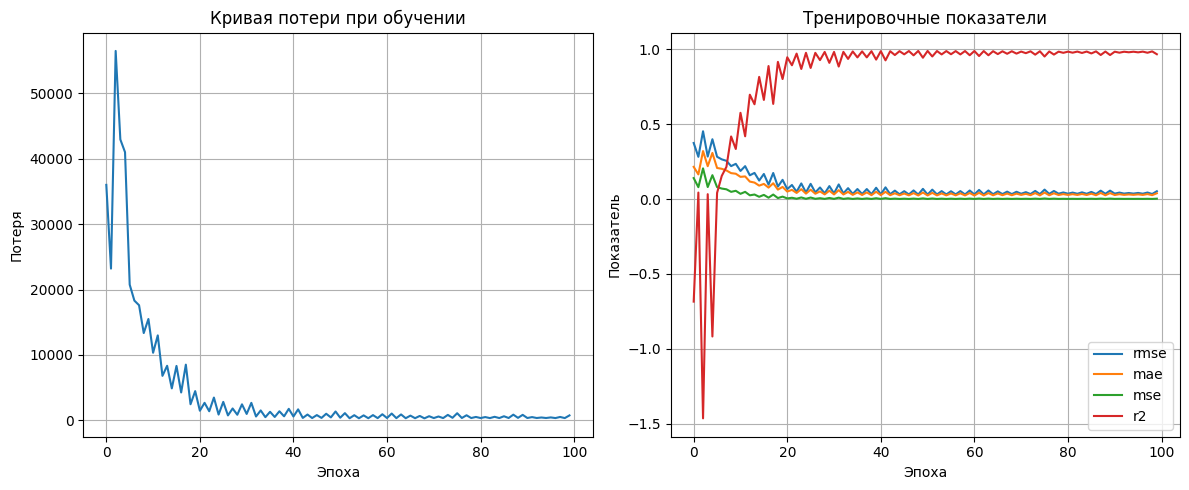

In [25]:
plot_training_history(
    train_results['train_loss'],
    titles=['Кривая потери при обучении', 'Тренировочные показатели'],
    metric_history={
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    },
)

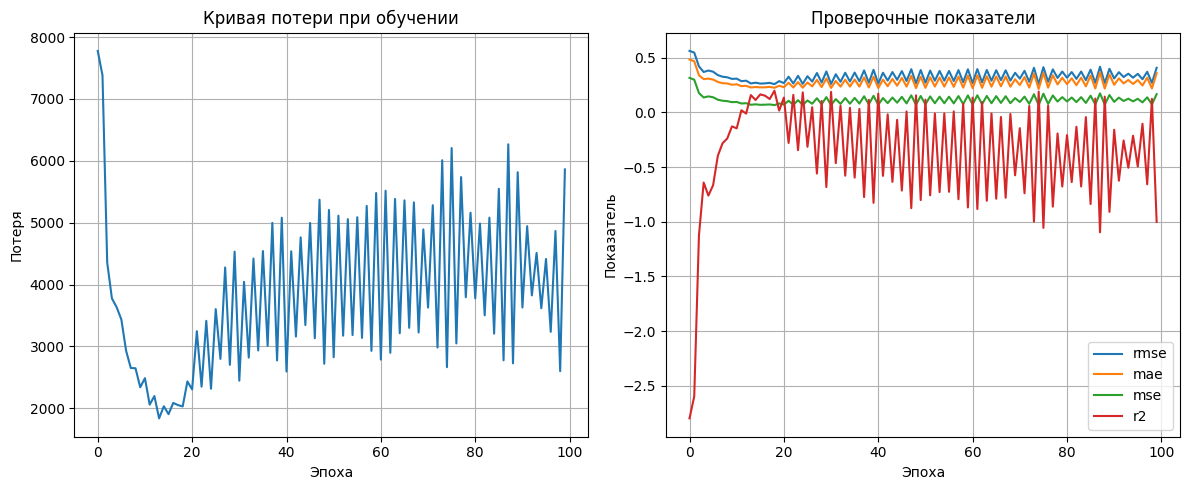

In [26]:
plot_training_history(
    train_results['val_loss'],
    metric_history={
        'rmse': train_results['val_rmse'],
        'mae': train_results['val_mae'],
        'mse': train_results['val_mse'],
        'r2': train_results['val_r2'],
    },
    titles=['Кривая потери при валидации', 'Проверочные показатели'],
)

In [256]:
len(test_loader)

94

In [27]:
# model.load_state_dict(torch.load('best_r2_model.pth', weights_only=True))

def test(
    model,
    test_loader,
    device,
):
    model.eval()

    test_preds = []
    test_targets = []

    test_r2 = []
    test_mae = []
    test_mse = []
    test_rmse = []
    
    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            data = data.to(device)
            labels = labels.to(device)
            predictions = model(data)
            
            # predictions = torch.cummin(predictions.flip(0), dim=0).values.flip(-1)

            test_preds.append(predictions)
            test_targets.append(labels)

        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_targets = torch.cat(test_targets).cpu().detach().numpy()

        mse = mean_squared_error(test_targets, test_preds)

        test_r2.append(r2_score(test_targets, test_preds))
        test_mae.append(mean_absolute_error(test_targets, test_preds))
        test_mse.append(mse)
        test_rmse.append(np.sqrt(mse))

    return {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_preds': test_preds,
        'test_targets': test_targets,
    }
          

In [28]:
# test_results = test(model, test_loader, device)

# test_results

In [16]:
# plot_predictions_vs_actuals(
#     test_results['test_targets'],
#     test_results['test_preds']
# )

In [17]:
# test_results['test_targets'], test_results['test_preds']

100%|██████████| 94/94 [00:00<00:00, 596.62it/s]


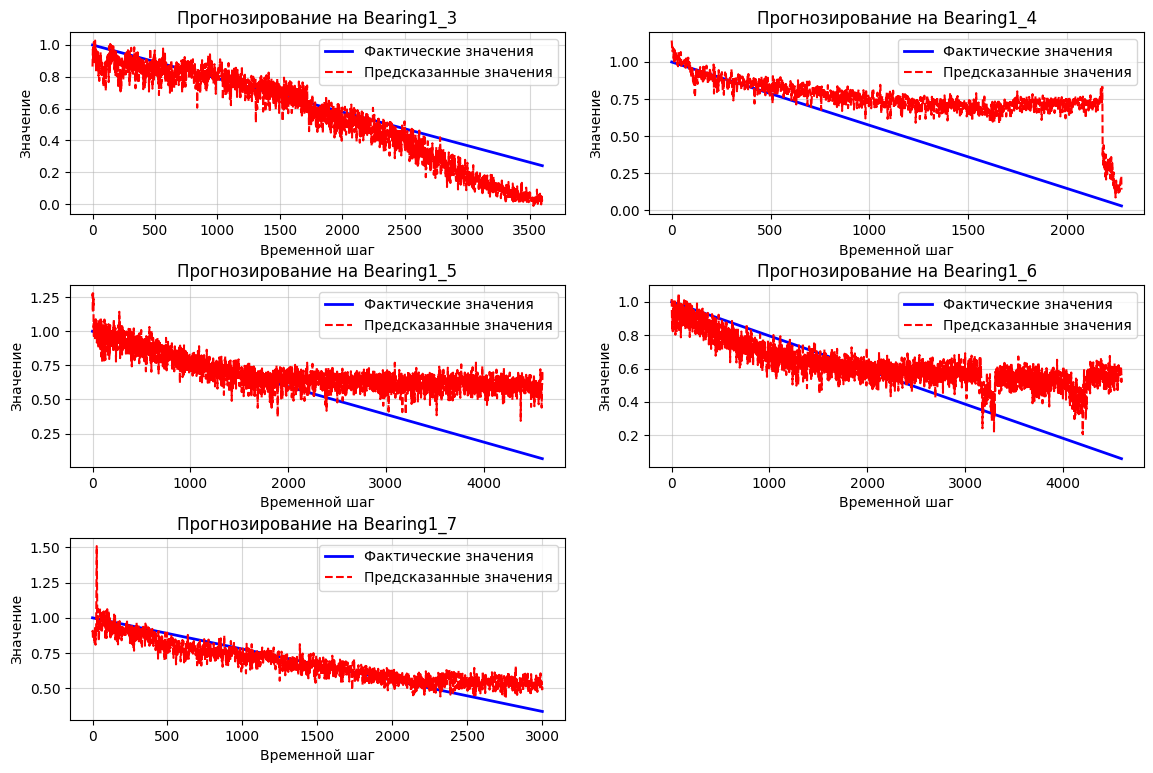

In [29]:
def get_test_results(condition):
    y_true_list = []
    y_pred_list = []
    titles = []
    test_results_list = []

    for bearing in TEST_BEARINGS[condition]:
        titles.append(f"Прогнозирование на Bearing" + bearing)

        test_dataset = BearingDataset(
            df=df[1][df[1]['unit'] == bearing],
        )

        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

        test_results = test(model, test_loader, device)
        y_true_list.append(test_results['test_targets'])
        y_pred_list.append(test_results['test_preds'])
        test_results_list.append({
            'test_r2': test_results['test_r2'],
            'test_mae': test_results['test_mae'],
            'test_mse': test_results['test_mse'],
            'test_rmse': test_results['test_rmse'],
        })
    
    return {
        'y_true_list': y_true_list,
        'y_pred_list': y_pred_list,
        'titles': titles,
        'test_results_list': test_results_list
    }

test_results = get_test_results(condition=1)

plot_predictions_grid(
    y_true_list=test_results['y_true_list'],
    y_pred_list=test_results['y_pred_list'],
    titles=test_results['titles'],
)

In [30]:
test_results['test_results_list']

[{'test_r2': [0.6944311020429162],
  'test_mae': [0.09382669],
  'test_mse': [0.014644166],
  'test_rmse': [0.12101308]},
 {'test_r2': [-0.21368198484304957],
  'test_mae': [0.24162544],
  'test_mse': [0.09522702],
  'test_rmse': [0.30858874]},
 {'test_r2': [0.15763497350440137],
  'test_mae': [0.1842854],
  'test_mse': [0.061271533],
  'test_rmse': [0.24753088]},
 {'test_r2': [0.42107196475095177],
  'test_mae': [0.16039012],
  'test_mse': [0.04262744],
  'test_rmse': [0.20646414]},
 {'test_r2': [0.7990789640741078],
  'test_mae': [0.066623345],
  'test_mse': [0.0073928433],
  'test_rmse': [0.085981645]}]

### Condition 2

In [55]:
train_dataset = BearingDataset(
    df=df[0][df[0]['unit'].isin(['2_1'])],
)

val_dataset = BearingDataset(
    df=df[0][df[0]['unit'] == '2_2'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [56]:
len(train_dataset), len(val_dataset)

(1820, 1592)

In [57]:
model = BearingCNN()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [58]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 100)

train_results

100%|██████████| 57/57 [00:00<00:00, 217.47it/s]


Epoch 1: Train Loss 6829.2168, Train R2 = -2.018, Train RMSE = 0.501, Train MSE = 0.251, Train MAE = 0.412


Epoch 1 Val: 100%|██████████| 50/50 [00:00<00:00, 516.83it/s]


Epoch 1: Val Loss 4335.7043, Val R2 = -1.507, Val RMSE = 0.457, Val MSE = 0.208, Val MAE = 0.374


100%|██████████| 57/57 [00:00<00:00, 245.61it/s]


Epoch 2: Train Loss 5304.6912, Train R2 = -1.335, Train RMSE = 0.441, Train MSE = 0.194, Train MAE = 0.359


Epoch 2 Val: 100%|██████████| 50/50 [00:00<00:00, 480.79it/s]


Epoch 2: Val Loss 3421.1088, Val R2 = -0.961, Val RMSE = 0.404, Val MSE = 0.163, Val MAE = 0.322


100%|██████████| 57/57 [00:00<00:00, 245.66it/s]


Epoch 3: Train Loss 4271.8248, Train R2 = -0.867, Train RMSE = 0.394, Train MSE = 0.155, Train MAE = 0.323


Epoch 3 Val: 100%|██████████| 50/50 [00:00<00:00, 500.71it/s]


Epoch 3: Val Loss 2907.4413, Val R2 = -0.640, Val RMSE = 0.369, Val MSE = 0.136, Val MAE = 0.294


100%|██████████| 57/57 [00:00<00:00, 237.02it/s]


Epoch 4: Train Loss 3682.3596, Train R2 = -0.599, Train RMSE = 0.365, Train MSE = 0.133, Train MAE = 0.303


Epoch 4 Val: 100%|██████████| 50/50 [00:00<00:00, 519.92it/s]


Epoch 4: Val Loss 2714.0012, Val R2 = -0.513, Val RMSE = 0.355, Val MSE = 0.126, Val MAE = 0.289


100%|██████████| 57/57 [00:00<00:00, 247.22it/s]


Epoch 5: Train Loss 3414.1693, Train R2 = -0.477, Train RMSE = 0.350, Train MSE = 0.123, Train MAE = 0.293


Epoch 5 Val: 100%|██████████| 50/50 [00:00<00:00, 533.95it/s]


Epoch 5: Val Loss 2625.4769, Val R2 = -0.455, Val RMSE = 0.348, Val MSE = 0.121, Val MAE = 0.288


100%|██████████| 57/57 [00:00<00:00, 241.28it/s]


Epoch 6: Train Loss 3274.7866, Train R2 = -0.414, Train RMSE = 0.343, Train MSE = 0.118, Train MAE = 0.287


Epoch 6 Val: 100%|██████████| 50/50 [00:00<00:00, 519.05it/s]


Epoch 6: Val Loss 2556.8251, Val R2 = -0.411, Val RMSE = 0.343, Val MSE = 0.117, Val MAE = 0.286


100%|██████████| 57/57 [00:00<00:00, 241.06it/s]


Epoch 7: Train Loss 3180.1313, Train R2 = -0.372, Train RMSE = 0.338, Train MSE = 0.114, Train MAE = 0.284


Epoch 7 Val: 100%|██████████| 50/50 [00:00<00:00, 556.02it/s]


Epoch 7: Val Loss 2498.2304, Val R2 = -0.376, Val RMSE = 0.338, Val MSE = 0.114, Val MAE = 0.284


100%|██████████| 57/57 [00:00<00:00, 238.90it/s]


Epoch 8: Train Loss 3108.4468, Train R2 = -0.340, Train RMSE = 0.334, Train MSE = 0.111, Train MAE = 0.281


Epoch 8 Val: 100%|██████████| 50/50 [00:00<00:00, 538.26it/s]


Epoch 8: Val Loss 2447.0612, Val R2 = -0.345, Val RMSE = 0.334, Val MSE = 0.112, Val MAE = 0.282


100%|██████████| 57/57 [00:00<00:00, 238.59it/s]


Epoch 9: Train Loss 3048.0309, Train R2 = -0.314, Train RMSE = 0.331, Train MSE = 0.109, Train MAE = 0.279


Epoch 9 Val: 100%|██████████| 50/50 [00:00<00:00, 528.41it/s]


Epoch 9: Val Loss 2402.1254, Val R2 = -0.319, Val RMSE = 0.331, Val MSE = 0.110, Val MAE = 0.280


100%|██████████| 57/57 [00:00<00:00, 244.23it/s]


Epoch 10: Train Loss 2995.7296, Train R2 = -0.291, Train RMSE = 0.328, Train MSE = 0.107, Train MAE = 0.278


Epoch 10 Val: 100%|██████████| 50/50 [00:00<00:00, 523.98it/s]


Epoch 10: Val Loss 2358.5933, Val R2 = -0.294, Val RMSE = 0.328, Val MSE = 0.108, Val MAE = 0.278


100%|██████████| 57/57 [00:00<00:00, 233.84it/s]


Epoch 11: Train Loss 2943.8331, Train R2 = -0.269, Train RMSE = 0.325, Train MSE = 0.106, Train MAE = 0.276


Epoch 11 Val: 100%|██████████| 50/50 [00:00<00:00, 512.05it/s]


Epoch 11: Val Loss 2317.1878, Val R2 = -0.270, Val RMSE = 0.325, Val MSE = 0.106, Val MAE = 0.277


100%|██████████| 57/57 [00:00<00:00, 241.64it/s]


Epoch 12: Train Loss 2896.7753, Train R2 = -0.249, Train RMSE = 0.322, Train MSE = 0.104, Train MAE = 0.274


Epoch 12 Val: 100%|██████████| 50/50 [00:00<00:00, 475.14it/s]


Epoch 12: Val Loss 2276.1844, Val R2 = -0.247, Val RMSE = 0.322, Val MSE = 0.104, Val MAE = 0.275


100%|██████████| 57/57 [00:00<00:00, 221.15it/s]


Epoch 13: Train Loss 2850.1216, Train R2 = -0.229, Train RMSE = 0.320, Train MSE = 0.102, Train MAE = 0.273


Epoch 13 Val: 100%|██████████| 50/50 [00:00<00:00, 458.86it/s]


Epoch 13: Val Loss 2234.8630, Val R2 = -0.223, Val RMSE = 0.319, Val MSE = 0.102, Val MAE = 0.273


100%|██████████| 57/57 [00:00<00:00, 245.42it/s]


Epoch 14: Train Loss 2807.1737, Train R2 = -0.211, Train RMSE = 0.317, Train MSE = 0.101, Train MAE = 0.272


Epoch 14 Val: 100%|██████████| 50/50 [00:00<00:00, 606.32it/s]


Epoch 14: Val Loss 2186.5054, Val R2 = -0.196, Val RMSE = 0.315, Val MSE = 0.099, Val MAE = 0.270


100%|██████████| 57/57 [00:00<00:00, 229.27it/s]


Epoch 15: Train Loss 2755.3185, Train R2 = -0.189, Train RMSE = 0.314, Train MSE = 0.099, Train MAE = 0.270


Epoch 15 Val: 100%|██████████| 50/50 [00:00<00:00, 532.14it/s]


Epoch 15: Val Loss 2149.3525, Val R2 = -0.175, Val RMSE = 0.313, Val MSE = 0.098, Val MAE = 0.269


100%|██████████| 57/57 [00:00<00:00, 230.46it/s]


Epoch 16: Train Loss 2719.5744, Train R2 = -0.174, Train RMSE = 0.312, Train MSE = 0.098, Train MAE = 0.269


Epoch 16 Val: 100%|██████████| 50/50 [00:00<00:00, 459.45it/s]


Epoch 16: Val Loss 2110.0091, Val R2 = -0.153, Val RMSE = 0.310, Val MSE = 0.096, Val MAE = 0.267


100%|██████████| 57/57 [00:00<00:00, 231.74it/s]


Epoch 17: Train Loss 2677.0596, Train R2 = -0.156, Train RMSE = 0.310, Train MSE = 0.096, Train MAE = 0.268


Epoch 17 Val: 100%|██████████| 50/50 [00:00<00:00, 477.99it/s]


Epoch 17: Val Loss 2070.7029, Val R2 = -0.131, Val RMSE = 0.307, Val MSE = 0.094, Val MAE = 0.265


100%|██████████| 57/57 [00:00<00:00, 248.38it/s]


Epoch 18: Train Loss 2637.5529, Train R2 = -0.140, Train RMSE = 0.308, Train MSE = 0.095, Train MAE = 0.266


Epoch 18 Val: 100%|██████████| 50/50 [00:00<00:00, 466.67it/s]


Epoch 18: Val Loss 2032.3675, Val R2 = -0.110, Val RMSE = 0.304, Val MSE = 0.092, Val MAE = 0.263


100%|██████████| 57/57 [00:00<00:00, 233.90it/s]


Epoch 19: Train Loss 2595.4669, Train R2 = -0.122, Train RMSE = 0.306, Train MSE = 0.093, Train MAE = 0.265


Epoch 19 Val: 100%|██████████| 50/50 [00:00<00:00, 480.75it/s]


Epoch 19: Val Loss 1995.9947, Val R2 = -0.091, Val RMSE = 0.301, Val MSE = 0.091, Val MAE = 0.261


100%|██████████| 57/57 [00:00<00:00, 243.64it/s]


Epoch 20: Train Loss 2558.0063, Train R2 = -0.107, Train RMSE = 0.303, Train MSE = 0.092, Train MAE = 0.264


Epoch 20 Val: 100%|██████████| 50/50 [00:00<00:00, 499.33it/s]


Epoch 20: Val Loss 1956.9273, Val R2 = -0.069, Val RMSE = 0.298, Val MSE = 0.089, Val MAE = 0.259


100%|██████████| 57/57 [00:00<00:00, 239.82it/s]


Epoch 21: Train Loss 2515.7895, Train R2 = -0.089, Train RMSE = 0.301, Train MSE = 0.091, Train MAE = 0.263


Epoch 21 Val: 100%|██████████| 50/50 [00:00<00:00, 412.67it/s]


Epoch 21: Val Loss 1917.3291, Val R2 = -0.048, Val RMSE = 0.295, Val MSE = 0.087, Val MAE = 0.257


100%|██████████| 57/57 [00:00<00:00, 241.65it/s]


Epoch 22: Train Loss 2481.2214, Train R2 = -0.075, Train RMSE = 0.299, Train MSE = 0.089, Train MAE = 0.262


Epoch 22 Val: 100%|██████████| 50/50 [00:00<00:00, 500.08it/s]


Epoch 22: Val Loss 1876.1343, Val R2 = -0.025, Val RMSE = 0.292, Val MSE = 0.085, Val MAE = 0.254


100%|██████████| 57/57 [00:00<00:00, 251.60it/s]


Epoch 23: Train Loss 2432.8552, Train R2 = -0.055, Train RMSE = 0.296, Train MSE = 0.088, Train MAE = 0.260


Epoch 23 Val: 100%|██████████| 50/50 [00:00<00:00, 521.97it/s]


Epoch 23: Val Loss 1835.7118, Val R2 = -0.003, Val RMSE = 0.289, Val MSE = 0.083, Val MAE = 0.252


100%|██████████| 57/57 [00:00<00:00, 246.68it/s]


Epoch 24: Train Loss 2390.2871, Train R2 = -0.038, Train RMSE = 0.294, Train MSE = 0.086, Train MAE = 0.259


Epoch 24 Val: 100%|██████████| 50/50 [00:00<00:00, 456.83it/s]


Epoch 24: Val Loss 1794.7848, Val R2 = 0.019, Val RMSE = 0.286, Val MSE = 0.082, Val MAE = 0.249


100%|██████████| 57/57 [00:00<00:00, 237.31it/s]


Epoch 25: Train Loss 2345.9972, Train R2 = -0.019, Train RMSE = 0.291, Train MSE = 0.085, Train MAE = 0.257


Epoch 25 Val: 100%|██████████| 50/50 [00:00<00:00, 533.74it/s]


Epoch 25: Val Loss 1752.7863, Val R2 = 0.042, Val RMSE = 0.282, Val MSE = 0.080, Val MAE = 0.247


100%|██████████| 57/57 [00:00<00:00, 247.09it/s]


Epoch 26: Train Loss 2300.0007, Train R2 = 0.000, Train RMSE = 0.288, Train MSE = 0.083, Train MAE = 0.256


Epoch 26 Val: 100%|██████████| 50/50 [00:00<00:00, 511.93it/s]


Epoch 26: Val Loss 1710.5952, Val R2 = 0.065, Val RMSE = 0.279, Val MSE = 0.078, Val MAE = 0.244


100%|██████████| 57/57 [00:00<00:00, 236.78it/s]


Epoch 27: Train Loss 2252.9168, Train R2 = 0.020, Train RMSE = 0.286, Train MSE = 0.082, Train MAE = 0.254


Epoch 27 Val: 100%|██████████| 50/50 [00:00<00:00, 491.31it/s]


Epoch 27: Val Loss 1668.7057, Val R2 = 0.088, Val RMSE = 0.275, Val MSE = 0.076, Val MAE = 0.242


100%|██████████| 57/57 [00:00<00:00, 243.91it/s]


Epoch 28: Train Loss 2205.9928, Train R2 = 0.039, Train RMSE = 0.283, Train MSE = 0.080, Train MAE = 0.252


Epoch 28 Val: 100%|██████████| 50/50 [00:00<00:00, 524.68it/s]


Epoch 28: Val Loss 1628.0936, Val R2 = 0.110, Val RMSE = 0.272, Val MSE = 0.074, Val MAE = 0.239


100%|██████████| 57/57 [00:00<00:00, 254.42it/s]


Epoch 29: Train Loss 2164.3388, Train R2 = 0.057, Train RMSE = 0.280, Train MSE = 0.078, Train MAE = 0.250


Epoch 29 Val: 100%|██████████| 50/50 [00:00<00:00, 479.82it/s]


Epoch 29: Val Loss 1590.9523, Val R2 = 0.131, Val RMSE = 0.269, Val MSE = 0.072, Val MAE = 0.236


100%|██████████| 57/57 [00:00<00:00, 225.51it/s]


Epoch 30: Train Loss 2117.6068, Train R2 = 0.077, Train RMSE = 0.277, Train MSE = 0.077, Train MAE = 0.248


Epoch 30 Val: 100%|██████████| 50/50 [00:00<00:00, 530.13it/s]


Epoch 30: Val Loss 1555.7637, Val R2 = 0.151, Val RMSE = 0.266, Val MSE = 0.071, Val MAE = 0.234


100%|██████████| 57/57 [00:00<00:00, 253.57it/s]


Epoch 31: Train Loss 2073.2015, Train R2 = 0.095, Train RMSE = 0.274, Train MSE = 0.075, Train MAE = 0.246


Epoch 31 Val: 100%|██████████| 50/50 [00:00<00:00, 479.29it/s]


Epoch 31: Val Loss 1523.2748, Val R2 = 0.169, Val RMSE = 0.263, Val MSE = 0.069, Val MAE = 0.231


100%|██████████| 57/57 [00:00<00:00, 241.58it/s]


Epoch 32: Train Loss 2029.8120, Train R2 = 0.114, Train RMSE = 0.271, Train MSE = 0.074, Train MAE = 0.244


Epoch 32 Val: 100%|██████████| 50/50 [00:00<00:00, 549.98it/s]


Epoch 32: Val Loss 1484.8553, Val R2 = 0.191, Val RMSE = 0.259, Val MSE = 0.067, Val MAE = 0.228


100%|██████████| 57/57 [00:00<00:00, 248.55it/s]


Epoch 33: Train Loss 1987.5116, Train R2 = 0.132, Train RMSE = 0.269, Train MSE = 0.072, Train MAE = 0.242


Epoch 33 Val: 100%|██████████| 50/50 [00:00<00:00, 513.49it/s]


Epoch 33: Val Loss 1456.9791, Val R2 = 0.206, Val RMSE = 0.257, Val MSE = 0.066, Val MAE = 0.225


100%|██████████| 57/57 [00:00<00:00, 228.74it/s]


Epoch 34: Train Loss 1945.6229, Train R2 = 0.150, Train RMSE = 0.266, Train MSE = 0.071, Train MAE = 0.240


Epoch 34 Val: 100%|██████████| 50/50 [00:00<00:00, 478.53it/s]


Epoch 34: Val Loss 1432.0665, Val R2 = 0.220, Val RMSE = 0.255, Val MSE = 0.065, Val MAE = 0.223


100%|██████████| 57/57 [00:00<00:00, 247.12it/s]


Epoch 35: Train Loss 1906.0040, Train R2 = 0.167, Train RMSE = 0.263, Train MSE = 0.069, Train MAE = 0.237


Epoch 35 Val: 100%|██████████| 50/50 [00:00<00:00, 521.68it/s]


Epoch 35: Val Loss 1408.7266, Val R2 = 0.233, Val RMSE = 0.252, Val MSE = 0.064, Val MAE = 0.220


100%|██████████| 57/57 [00:00<00:00, 255.20it/s]


Epoch 36: Train Loss 1870.0469, Train R2 = 0.182, Train RMSE = 0.261, Train MSE = 0.068, Train MAE = 0.235


Epoch 36 Val: 100%|██████████| 50/50 [00:00<00:00, 458.87it/s]


Epoch 36: Val Loss 1388.0533, Val R2 = 0.245, Val RMSE = 0.251, Val MSE = 0.063, Val MAE = 0.218


100%|██████████| 57/57 [00:00<00:00, 222.21it/s]


Epoch 37: Train Loss 1833.2278, Train R2 = 0.198, Train RMSE = 0.258, Train MSE = 0.067, Train MAE = 0.232


Epoch 37 Val: 100%|██████████| 50/50 [00:00<00:00, 512.70it/s]


Epoch 37: Val Loss 1367.5904, Val R2 = 0.256, Val RMSE = 0.249, Val MSE = 0.062, Val MAE = 0.216


100%|██████████| 57/57 [00:00<00:00, 250.16it/s]


Epoch 38: Train Loss 1799.3853, Train R2 = 0.212, Train RMSE = 0.256, Train MSE = 0.066, Train MAE = 0.230


Epoch 38 Val: 100%|██████████| 50/50 [00:00<00:00, 517.30it/s]


Epoch 38: Val Loss 1345.1746, Val R2 = 0.269, Val RMSE = 0.247, Val MSE = 0.061, Val MAE = 0.212


100%|██████████| 57/57 [00:00<00:00, 228.18it/s]


Epoch 39: Train Loss 1760.5810, Train R2 = 0.229, Train RMSE = 0.253, Train MSE = 0.064, Train MAE = 0.227


Epoch 39 Val: 100%|██████████| 50/50 [00:00<00:00, 505.29it/s]


Epoch 39: Val Loss 1323.1483, Val R2 = 0.280, Val RMSE = 0.245, Val MSE = 0.060, Val MAE = 0.210


100%|██████████| 57/57 [00:00<00:00, 251.48it/s]


Epoch 40: Train Loss 1735.6247, Train R2 = 0.240, Train RMSE = 0.251, Train MSE = 0.063, Train MAE = 0.225


Epoch 40 Val: 100%|██████████| 50/50 [00:00<00:00, 502.47it/s]


Epoch 40: Val Loss 1312.0917, Val R2 = 0.287, Val RMSE = 0.244, Val MSE = 0.059, Val MAE = 0.207


100%|██████████| 57/57 [00:00<00:00, 237.42it/s]


Epoch 41: Train Loss 1702.4281, Train R2 = 0.254, Train RMSE = 0.249, Train MSE = 0.062, Train MAE = 0.222


Epoch 41 Val: 100%|██████████| 50/50 [00:00<00:00, 494.53it/s]


Epoch 41: Val Loss 1297.6491, Val R2 = 0.294, Val RMSE = 0.242, Val MSE = 0.059, Val MAE = 0.205


100%|██████████| 57/57 [00:00<00:00, 241.37it/s]


Epoch 42: Train Loss 1678.4942, Train R2 = 0.264, Train RMSE = 0.247, Train MSE = 0.061, Train MAE = 0.220


Epoch 42 Val: 100%|██████████| 50/50 [00:00<00:00, 493.65it/s]


Epoch 42: Val Loss 1288.4860, Val R2 = 0.299, Val RMSE = 0.241, Val MSE = 0.058, Val MAE = 0.202


100%|██████████| 57/57 [00:00<00:00, 244.88it/s]


Epoch 43: Train Loss 1653.7154, Train R2 = 0.275, Train RMSE = 0.246, Train MSE = 0.060, Train MAE = 0.217


Epoch 43 Val: 100%|██████████| 50/50 [00:00<00:00, 491.75it/s]


Epoch 43: Val Loss 1281.1238, Val R2 = 0.303, Val RMSE = 0.241, Val MSE = 0.058, Val MAE = 0.200


100%|██████████| 57/57 [00:00<00:00, 231.28it/s]


Epoch 44: Train Loss 1632.2087, Train R2 = 0.284, Train RMSE = 0.244, Train MSE = 0.060, Train MAE = 0.215


Epoch 44 Val: 100%|██████████| 50/50 [00:00<00:00, 509.90it/s]


Epoch 44: Val Loss 1276.4033, Val R2 = 0.306, Val RMSE = 0.240, Val MSE = 0.058, Val MAE = 0.198


100%|██████████| 57/57 [00:00<00:00, 242.51it/s]


Epoch 45: Train Loss 1612.2038, Train R2 = 0.292, Train RMSE = 0.243, Train MSE = 0.059, Train MAE = 0.213


Epoch 45 Val: 100%|██████████| 50/50 [00:00<00:00, 507.82it/s]


Epoch 45: Val Loss 1272.2758, Val R2 = 0.308, Val RMSE = 0.240, Val MSE = 0.058, Val MAE = 0.195


100%|██████████| 57/57 [00:00<00:00, 211.65it/s]


Epoch 46: Train Loss 1594.6114, Train R2 = 0.300, Train RMSE = 0.241, Train MSE = 0.058, Train MAE = 0.211


Epoch 46 Val: 100%|██████████| 50/50 [00:00<00:00, 507.87it/s]


Epoch 46: Val Loss 1268.7786, Val R2 = 0.309, Val RMSE = 0.240, Val MSE = 0.057, Val MAE = 0.193


100%|██████████| 57/57 [00:00<00:00, 241.08it/s]


Epoch 47: Train Loss 1578.7750, Train R2 = 0.307, Train RMSE = 0.240, Train MSE = 0.058, Train MAE = 0.209


Epoch 47 Val: 100%|██████████| 50/50 [00:00<00:00, 516.03it/s]


Epoch 47: Val Loss 1265.2589, Val R2 = 0.311, Val RMSE = 0.239, Val MSE = 0.057, Val MAE = 0.192


100%|██████████| 57/57 [00:00<00:00, 220.40it/s]


Epoch 48: Train Loss 1564.7965, Train R2 = 0.313, Train RMSE = 0.239, Train MSE = 0.057, Train MAE = 0.207


Epoch 48 Val: 100%|██████████| 50/50 [00:00<00:00, 468.76it/s]


Epoch 48: Val Loss 1262.1384, Val R2 = 0.312, Val RMSE = 0.239, Val MSE = 0.057, Val MAE = 0.190


100%|██████████| 57/57 [00:00<00:00, 238.03it/s]


Epoch 49: Train Loss 1552.1134, Train R2 = 0.318, Train RMSE = 0.238, Train MSE = 0.057, Train MAE = 0.205


Epoch 49 Val: 100%|██████████| 50/50 [00:00<00:00, 477.38it/s]


Epoch 49: Val Loss 1258.8548, Val R2 = 0.313, Val RMSE = 0.239, Val MSE = 0.057, Val MAE = 0.188


100%|██████████| 57/57 [00:00<00:00, 237.36it/s]


Epoch 50: Train Loss 1540.6608, Train R2 = 0.323, Train RMSE = 0.237, Train MSE = 0.056, Train MAE = 0.203


Epoch 50 Val: 100%|██████████| 50/50 [00:00<00:00, 526.32it/s]


Epoch 50: Val Loss 1255.7635, Val R2 = 0.314, Val RMSE = 0.239, Val MSE = 0.057, Val MAE = 0.187


100%|██████████| 57/57 [00:00<00:00, 228.15it/s]


Epoch 51: Train Loss 1530.0491, Train R2 = 0.327, Train RMSE = 0.236, Train MSE = 0.056, Train MAE = 0.202


Epoch 51 Val: 100%|██████████| 50/50 [00:00<00:00, 462.93it/s]


Epoch 51: Val Loss 1252.4114, Val R2 = 0.315, Val RMSE = 0.239, Val MSE = 0.057, Val MAE = 0.186


100%|██████████| 57/57 [00:00<00:00, 231.63it/s]


Epoch 52: Train Loss 1520.3374, Train R2 = 0.332, Train RMSE = 0.236, Train MSE = 0.056, Train MAE = 0.200


Epoch 52 Val: 100%|██████████| 50/50 [00:00<00:00, 495.93it/s]


Epoch 52: Val Loss 1249.4679, Val R2 = 0.316, Val RMSE = 0.238, Val MSE = 0.057, Val MAE = 0.185


100%|██████████| 57/57 [00:00<00:00, 234.66it/s]


Epoch 53: Train Loss 1510.8444, Train R2 = 0.336, Train RMSE = 0.235, Train MSE = 0.055, Train MAE = 0.199


Epoch 53 Val: 100%|██████████| 50/50 [00:00<00:00, 467.56it/s]


Epoch 53: Val Loss 1246.0195, Val R2 = 0.318, Val RMSE = 0.238, Val MSE = 0.057, Val MAE = 0.184


100%|██████████| 57/57 [00:00<00:00, 234.55it/s]


Epoch 54: Train Loss 1502.4609, Train R2 = 0.339, Train RMSE = 0.234, Train MSE = 0.055, Train MAE = 0.198


Epoch 54 Val: 100%|██████████| 50/50 [00:00<00:00, 512.26it/s]


Epoch 54: Val Loss 1243.0044, Val R2 = 0.319, Val RMSE = 0.238, Val MSE = 0.057, Val MAE = 0.184


100%|██████████| 57/57 [00:00<00:00, 216.67it/s]


Epoch 55: Train Loss 1494.1393, Train R2 = 0.343, Train RMSE = 0.234, Train MSE = 0.055, Train MAE = 0.197


Epoch 55 Val: 100%|██████████| 50/50 [00:00<00:00, 452.96it/s]


Epoch 55: Val Loss 1239.7411, Val R2 = 0.320, Val RMSE = 0.238, Val MSE = 0.057, Val MAE = 0.183


100%|██████████| 57/57 [00:00<00:00, 230.33it/s]


Epoch 56: Train Loss 1486.3029, Train R2 = 0.346, Train RMSE = 0.233, Train MSE = 0.054, Train MAE = 0.195


Epoch 56 Val: 100%|██████████| 50/50 [00:00<00:00, 505.54it/s]


Epoch 56: Val Loss 1236.0595, Val R2 = 0.321, Val RMSE = 0.238, Val MSE = 0.056, Val MAE = 0.183


100%|██████████| 57/57 [00:00<00:00, 238.85it/s]


Epoch 57: Train Loss 1479.1164, Train R2 = 0.349, Train RMSE = 0.233, Train MSE = 0.054, Train MAE = 0.194


Epoch 57 Val: 100%|██████████| 50/50 [00:00<00:00, 510.05it/s]


Epoch 57: Val Loss 1232.5508, Val R2 = 0.323, Val RMSE = 0.237, Val MSE = 0.056, Val MAE = 0.182


100%|██████████| 57/57 [00:00<00:00, 239.28it/s]


Epoch 58: Train Loss 1472.1437, Train R2 = 0.352, Train RMSE = 0.232, Train MSE = 0.054, Train MAE = 0.193


Epoch 58 Val: 100%|██████████| 50/50 [00:00<00:00, 506.81it/s]


Epoch 58: Val Loss 1228.7901, Val R2 = 0.324, Val RMSE = 0.237, Val MSE = 0.056, Val MAE = 0.182


100%|██████████| 57/57 [00:00<00:00, 239.60it/s]


Epoch 59: Train Loss 1465.5485, Train R2 = 0.355, Train RMSE = 0.232, Train MSE = 0.054, Train MAE = 0.192


Epoch 59 Val: 100%|██████████| 50/50 [00:00<00:00, 492.30it/s]


Epoch 59: Val Loss 1224.9005, Val R2 = 0.326, Val RMSE = 0.237, Val MSE = 0.056, Val MAE = 0.181


100%|██████████| 57/57 [00:00<00:00, 238.64it/s]


Epoch 60: Train Loss 1459.1273, Train R2 = 0.358, Train RMSE = 0.231, Train MSE = 0.053, Train MAE = 0.191


Epoch 60 Val: 100%|██████████| 50/50 [00:00<00:00, 502.69it/s]


Epoch 60: Val Loss 1220.7997, Val R2 = 0.327, Val RMSE = 0.236, Val MSE = 0.056, Val MAE = 0.181


100%|██████████| 57/57 [00:00<00:00, 238.62it/s]


Epoch 61: Train Loss 1453.3121, Train R2 = 0.360, Train RMSE = 0.231, Train MSE = 0.053, Train MAE = 0.191


Epoch 61 Val: 100%|██████████| 50/50 [00:00<00:00, 489.13it/s]


Epoch 61: Val Loss 1216.9148, Val R2 = 0.329, Val RMSE = 0.236, Val MSE = 0.056, Val MAE = 0.181


100%|██████████| 57/57 [00:00<00:00, 221.73it/s]


Epoch 62: Train Loss 1447.2663, Train R2 = 0.363, Train RMSE = 0.230, Train MSE = 0.053, Train MAE = 0.190


Epoch 62 Val: 100%|██████████| 50/50 [00:00<00:00, 469.68it/s]


Epoch 62: Val Loss 1212.6464, Val R2 = 0.331, Val RMSE = 0.236, Val MSE = 0.056, Val MAE = 0.181


100%|██████████| 57/57 [00:00<00:00, 237.11it/s]


Epoch 63: Train Loss 1441.7871, Train R2 = 0.365, Train RMSE = 0.230, Train MSE = 0.053, Train MAE = 0.189


Epoch 63 Val: 100%|██████████| 50/50 [00:00<00:00, 489.53it/s]


Epoch 63: Val Loss 1208.4938, Val R2 = 0.332, Val RMSE = 0.236, Val MSE = 0.056, Val MAE = 0.180


100%|██████████| 57/57 [00:00<00:00, 228.24it/s]


Epoch 64: Train Loss 1436.3728, Train R2 = 0.367, Train RMSE = 0.229, Train MSE = 0.053, Train MAE = 0.189


Epoch 64 Val: 100%|██████████| 50/50 [00:00<00:00, 446.46it/s]


Epoch 64: Val Loss 1204.3718, Val R2 = 0.334, Val RMSE = 0.235, Val MSE = 0.055, Val MAE = 0.180


100%|██████████| 57/57 [00:00<00:00, 225.02it/s]


Epoch 65: Train Loss 1431.0444, Train R2 = 0.369, Train RMSE = 0.229, Train MSE = 0.052, Train MAE = 0.188


Epoch 65 Val: 100%|██████████| 50/50 [00:00<00:00, 511.66it/s]


Epoch 65: Val Loss 1200.0146, Val R2 = 0.336, Val RMSE = 0.235, Val MSE = 0.055, Val MAE = 0.180


100%|██████████| 57/57 [00:00<00:00, 234.45it/s]


Epoch 66: Train Loss 1426.1276, Train R2 = 0.372, Train RMSE = 0.229, Train MSE = 0.052, Train MAE = 0.188


Epoch 66 Val: 100%|██████████| 50/50 [00:00<00:00, 520.43it/s]


Epoch 66: Val Loss 1195.8627, Val R2 = 0.338, Val RMSE = 0.235, Val MSE = 0.055, Val MAE = 0.180


100%|██████████| 57/57 [00:00<00:00, 227.26it/s]


Epoch 67: Train Loss 1421.0211, Train R2 = 0.374, Train RMSE = 0.228, Train MSE = 0.052, Train MAE = 0.187


Epoch 67 Val: 100%|██████████| 50/50 [00:00<00:00, 511.10it/s]


Epoch 67: Val Loss 1191.3925, Val R2 = 0.339, Val RMSE = 0.234, Val MSE = 0.055, Val MAE = 0.180


100%|██████████| 57/57 [00:00<00:00, 240.58it/s]


Epoch 68: Train Loss 1416.2683, Train R2 = 0.376, Train RMSE = 0.228, Train MSE = 0.052, Train MAE = 0.187


Epoch 68 Val: 100%|██████████| 50/50 [00:00<00:00, 501.06it/s]


Epoch 68: Val Loss 1187.1477, Val R2 = 0.341, Val RMSE = 0.234, Val MSE = 0.055, Val MAE = 0.179


100%|██████████| 57/57 [00:00<00:00, 224.77it/s]


Epoch 69: Train Loss 1411.5511, Train R2 = 0.378, Train RMSE = 0.227, Train MSE = 0.052, Train MAE = 0.186


Epoch 69 Val: 100%|██████████| 50/50 [00:00<00:00, 492.87it/s]


Epoch 69: Val Loss 1182.9318, Val R2 = 0.343, Val RMSE = 0.234, Val MSE = 0.055, Val MAE = 0.179


100%|██████████| 57/57 [00:00<00:00, 239.02it/s]


Epoch 70: Train Loss 1406.9263, Train R2 = 0.380, Train RMSE = 0.227, Train MSE = 0.052, Train MAE = 0.186


Epoch 70 Val: 100%|██████████| 50/50 [00:00<00:00, 509.52it/s]


Epoch 70: Val Loss 1178.4975, Val R2 = 0.345, Val RMSE = 0.233, Val MSE = 0.054, Val MAE = 0.179


100%|██████████| 57/57 [00:00<00:00, 221.05it/s]


Epoch 71: Train Loss 1402.5460, Train R2 = 0.382, Train RMSE = 0.227, Train MSE = 0.051, Train MAE = 0.186


Epoch 71 Val: 100%|██████████| 50/50 [00:00<00:00, 458.53it/s]


Epoch 71: Val Loss 1174.2871, Val R2 = 0.347, Val RMSE = 0.233, Val MSE = 0.054, Val MAE = 0.179


100%|██████████| 57/57 [00:00<00:00, 232.68it/s]


Epoch 72: Train Loss 1397.9943, Train R2 = 0.384, Train RMSE = 0.226, Train MSE = 0.051, Train MAE = 0.185


Epoch 72 Val: 100%|██████████| 50/50 [00:00<00:00, 462.55it/s]


Epoch 72: Val Loss 1169.9159, Val R2 = 0.348, Val RMSE = 0.233, Val MSE = 0.054, Val MAE = 0.179


100%|██████████| 57/57 [00:00<00:00, 226.60it/s]


Epoch 73: Train Loss 1393.8514, Train R2 = 0.385, Train RMSE = 0.226, Train MSE = 0.051, Train MAE = 0.185


Epoch 73 Val: 100%|██████████| 50/50 [00:00<00:00, 394.69it/s]


Epoch 73: Val Loss 1165.7630, Val R2 = 0.350, Val RMSE = 0.232, Val MSE = 0.054, Val MAE = 0.178


100%|██████████| 57/57 [00:00<00:00, 236.23it/s]


Epoch 74: Train Loss 1389.5817, Train R2 = 0.387, Train RMSE = 0.226, Train MSE = 0.051, Train MAE = 0.184


Epoch 74 Val: 100%|██████████| 50/50 [00:00<00:00, 500.89it/s]


Epoch 74: Val Loss 1161.5939, Val R2 = 0.352, Val RMSE = 0.232, Val MSE = 0.054, Val MAE = 0.178


100%|██████████| 57/57 [00:00<00:00, 239.32it/s]


Epoch 75: Train Loss 1385.5886, Train R2 = 0.389, Train RMSE = 0.225, Train MSE = 0.051, Train MAE = 0.184


Epoch 75 Val: 100%|██████████| 50/50 [00:00<00:00, 437.92it/s]


Epoch 75: Val Loss 1157.6516, Val R2 = 0.354, Val RMSE = 0.232, Val MSE = 0.054, Val MAE = 0.178


100%|██████████| 57/57 [00:00<00:00, 217.95it/s]


Epoch 76: Train Loss 1381.5953, Train R2 = 0.391, Train RMSE = 0.225, Train MSE = 0.051, Train MAE = 0.184


Epoch 76 Val: 100%|██████████| 50/50 [00:00<00:00, 513.25it/s]


Epoch 76: Val Loss 1153.6069, Val R2 = 0.355, Val RMSE = 0.232, Val MSE = 0.054, Val MAE = 0.178


100%|██████████| 57/57 [00:00<00:00, 238.16it/s]


Epoch 77: Train Loss 1377.7389, Train R2 = 0.392, Train RMSE = 0.225, Train MSE = 0.051, Train MAE = 0.183


Epoch 77 Val: 100%|██████████| 50/50 [00:00<00:00, 513.22it/s]


Epoch 77: Val Loss 1149.6301, Val R2 = 0.357, Val RMSE = 0.231, Val MSE = 0.053, Val MAE = 0.178


100%|██████████| 57/57 [00:00<00:00, 235.22it/s]


Epoch 78: Train Loss 1373.9356, Train R2 = 0.394, Train RMSE = 0.225, Train MSE = 0.050, Train MAE = 0.183


Epoch 78 Val: 100%|██████████| 50/50 [00:00<00:00, 477.96it/s]


Epoch 78: Val Loss 1145.7319, Val R2 = 0.359, Val RMSE = 0.231, Val MSE = 0.053, Val MAE = 0.178


100%|██████████| 57/57 [00:00<00:00, 228.03it/s]


Epoch 79: Train Loss 1370.2810, Train R2 = 0.395, Train RMSE = 0.224, Train MSE = 0.050, Train MAE = 0.183


Epoch 79 Val: 100%|██████████| 50/50 [00:00<00:00, 447.31it/s]


Epoch 79: Val Loss 1142.0002, Val R2 = 0.360, Val RMSE = 0.231, Val MSE = 0.053, Val MAE = 0.177


100%|██████████| 57/57 [00:00<00:00, 231.97it/s]


Epoch 80: Train Loss 1366.7286, Train R2 = 0.397, Train RMSE = 0.224, Train MSE = 0.050, Train MAE = 0.183


Epoch 80 Val: 100%|██████████| 50/50 [00:00<00:00, 426.95it/s]


Epoch 80: Val Loss 1138.4216, Val R2 = 0.362, Val RMSE = 0.230, Val MSE = 0.053, Val MAE = 0.177


100%|██████████| 57/57 [00:00<00:00, 227.11it/s]


Epoch 81: Train Loss 1363.0813, Train R2 = 0.398, Train RMSE = 0.224, Train MSE = 0.050, Train MAE = 0.182


Epoch 81 Val: 100%|██████████| 50/50 [00:00<00:00, 491.40it/s]


Epoch 81: Val Loss 1134.8144, Val R2 = 0.363, Val RMSE = 0.230, Val MSE = 0.053, Val MAE = 0.177


100%|██████████| 57/57 [00:00<00:00, 236.21it/s]


Epoch 82: Train Loss 1359.5230, Train R2 = 0.400, Train RMSE = 0.223, Train MSE = 0.050, Train MAE = 0.182


Epoch 82 Val: 100%|██████████| 50/50 [00:00<00:00, 417.20it/s]


Epoch 82: Val Loss 1131.3051, Val R2 = 0.365, Val RMSE = 0.230, Val MSE = 0.053, Val MAE = 0.177


100%|██████████| 57/57 [00:00<00:00, 226.96it/s]


Epoch 83: Train Loss 1356.2606, Train R2 = 0.401, Train RMSE = 0.223, Train MSE = 0.050, Train MAE = 0.182


Epoch 83 Val: 100%|██████████| 50/50 [00:00<00:00, 457.96it/s]


Epoch 83: Val Loss 1127.6165, Val R2 = 0.367, Val RMSE = 0.229, Val MSE = 0.053, Val MAE = 0.177


100%|██████████| 57/57 [00:00<00:00, 215.36it/s]


Epoch 84: Train Loss 1352.9683, Train R2 = 0.403, Train RMSE = 0.223, Train MSE = 0.050, Train MAE = 0.182


Epoch 84 Val: 100%|██████████| 50/50 [00:00<00:00, 447.94it/s]


Epoch 84: Val Loss 1124.3185, Val R2 = 0.368, Val RMSE = 0.229, Val MSE = 0.053, Val MAE = 0.177


100%|██████████| 57/57 [00:00<00:00, 232.44it/s]


Epoch 85: Train Loss 1349.5083, Train R2 = 0.404, Train RMSE = 0.223, Train MSE = 0.050, Train MAE = 0.181


Epoch 85 Val: 100%|██████████| 50/50 [00:00<00:00, 508.59it/s]


Epoch 85: Val Loss 1120.9054, Val R2 = 0.369, Val RMSE = 0.229, Val MSE = 0.052, Val MAE = 0.177


100%|██████████| 57/57 [00:00<00:00, 220.19it/s]


Epoch 86: Train Loss 1346.3293, Train R2 = 0.406, Train RMSE = 0.222, Train MSE = 0.049, Train MAE = 0.181


Epoch 86 Val: 100%|██████████| 50/50 [00:00<00:00, 512.83it/s]


Epoch 86: Val Loss 1117.7139, Val R2 = 0.371, Val RMSE = 0.229, Val MSE = 0.052, Val MAE = 0.176


100%|██████████| 57/57 [00:00<00:00, 238.64it/s]


Epoch 87: Train Loss 1343.1293, Train R2 = 0.407, Train RMSE = 0.222, Train MSE = 0.049, Train MAE = 0.181


Epoch 87 Val: 100%|██████████| 50/50 [00:00<00:00, 468.54it/s]


Epoch 87: Val Loss 1114.4908, Val R2 = 0.372, Val RMSE = 0.228, Val MSE = 0.052, Val MAE = 0.176


100%|██████████| 57/57 [00:00<00:00, 227.13it/s]


Epoch 88: Train Loss 1339.8399, Train R2 = 0.408, Train RMSE = 0.222, Train MSE = 0.049, Train MAE = 0.181


Epoch 88 Val: 100%|██████████| 50/50 [00:00<00:00, 516.41it/s]


Epoch 88: Val Loss 1112.2331, Val R2 = 0.373, Val RMSE = 0.228, Val MSE = 0.052, Val MAE = 0.176


100%|██████████| 57/57 [00:00<00:00, 223.53it/s]


Epoch 89: Train Loss 1334.3613, Train R2 = 0.411, Train RMSE = 0.221, Train MSE = 0.049, Train MAE = 0.180


Epoch 89 Val: 100%|██████████| 50/50 [00:00<00:00, 468.35it/s]


Epoch 89: Val Loss 1110.3301, Val R2 = 0.374, Val RMSE = 0.228, Val MSE = 0.052, Val MAE = 0.176


100%|██████████| 57/57 [00:00<00:00, 225.84it/s]


Epoch 90: Train Loss 1331.6557, Train R2 = 0.412, Train RMSE = 0.221, Train MSE = 0.049, Train MAE = 0.180


Epoch 90 Val: 100%|██████████| 50/50 [00:00<00:00, 459.19it/s]


Epoch 90: Val Loss 1106.1955, Val R2 = 0.376, Val RMSE = 0.228, Val MSE = 0.052, Val MAE = 0.176


100%|██████████| 57/57 [00:00<00:00, 216.63it/s]


Epoch 91: Train Loss 1328.1914, Train R2 = 0.414, Train RMSE = 0.221, Train MSE = 0.049, Train MAE = 0.180


Epoch 91 Val: 100%|██████████| 50/50 [00:00<00:00, 397.64it/s]


Epoch 91: Val Loss 1104.0623, Val R2 = 0.376, Val RMSE = 0.228, Val MSE = 0.052, Val MAE = 0.176


100%|██████████| 57/57 [00:00<00:00, 224.20it/s]


Epoch 92: Train Loss 1325.1526, Train R2 = 0.415, Train RMSE = 0.221, Train MSE = 0.049, Train MAE = 0.180


Epoch 92 Val: 100%|██████████| 50/50 [00:00<00:00, 477.13it/s]


Epoch 92: Val Loss 1100.8739, Val R2 = 0.378, Val RMSE = 0.227, Val MSE = 0.052, Val MAE = 0.176


100%|██████████| 57/57 [00:00<00:00, 226.96it/s]


Epoch 93: Train Loss 1322.9618, Train R2 = 0.416, Train RMSE = 0.220, Train MSE = 0.049, Train MAE = 0.180


Epoch 93 Val: 100%|██████████| 50/50 [00:00<00:00, 459.57it/s]


Epoch 93: Val Loss 1098.6678, Val R2 = 0.379, Val RMSE = 0.227, Val MSE = 0.052, Val MAE = 0.176


100%|██████████| 57/57 [00:00<00:00, 225.63it/s]


Epoch 94: Train Loss 1319.7490, Train R2 = 0.417, Train RMSE = 0.220, Train MSE = 0.048, Train MAE = 0.179


Epoch 94 Val: 100%|██████████| 50/50 [00:00<00:00, 462.04it/s]


Epoch 94: Val Loss 1095.7265, Val R2 = 0.380, Val RMSE = 0.227, Val MSE = 0.052, Val MAE = 0.176


100%|██████████| 57/57 [00:00<00:00, 224.87it/s]


Epoch 95: Train Loss 1317.2819, Train R2 = 0.418, Train RMSE = 0.220, Train MSE = 0.048, Train MAE = 0.179


Epoch 95 Val: 100%|██████████| 50/50 [00:00<00:00, 480.66it/s]


Epoch 95: Val Loss 1093.1572, Val R2 = 0.381, Val RMSE = 0.227, Val MSE = 0.051, Val MAE = 0.175


100%|██████████| 57/57 [00:00<00:00, 229.94it/s]


Epoch 96: Train Loss 1314.6143, Train R2 = 0.420, Train RMSE = 0.220, Train MSE = 0.048, Train MAE = 0.179


Epoch 96 Val: 100%|██████████| 50/50 [00:00<00:00, 481.08it/s]


Epoch 96: Val Loss 1090.4235, Val R2 = 0.382, Val RMSE = 0.227, Val MSE = 0.051, Val MAE = 0.175


100%|██████████| 57/57 [00:00<00:00, 209.42it/s]


Epoch 97: Train Loss 1312.1704, Train R2 = 0.421, Train RMSE = 0.220, Train MSE = 0.048, Train MAE = 0.179


Epoch 97 Val: 100%|██████████| 50/50 [00:00<00:00, 484.41it/s]


Epoch 97: Val Loss 1088.1262, Val R2 = 0.383, Val RMSE = 0.226, Val MSE = 0.051, Val MAE = 0.175


100%|██████████| 57/57 [00:00<00:00, 225.11it/s]


Epoch 98: Train Loss 1309.6796, Train R2 = 0.422, Train RMSE = 0.219, Train MSE = 0.048, Train MAE = 0.179


Epoch 98 Val: 100%|██████████| 50/50 [00:00<00:00, 470.59it/s]


Epoch 98: Val Loss 1085.5636, Val R2 = 0.384, Val RMSE = 0.226, Val MSE = 0.051, Val MAE = 0.175


100%|██████████| 57/57 [00:00<00:00, 224.09it/s]


Epoch 99: Train Loss 1307.4012, Train R2 = 0.423, Train RMSE = 0.219, Train MSE = 0.048, Train MAE = 0.179


Epoch 99 Val: 100%|██████████| 50/50 [00:00<00:00, 489.53it/s]


Epoch 99: Val Loss 1083.4618, Val R2 = 0.385, Val RMSE = 0.226, Val MSE = 0.051, Val MAE = 0.175


100%|██████████| 57/57 [00:00<00:00, 231.44it/s]


Epoch 100: Train Loss 1304.9837, Train R2 = 0.424, Train RMSE = 0.219, Train MSE = 0.048, Train MAE = 0.178


Epoch 100 Val: 100%|██████████| 50/50 [00:00<00:00, 512.99it/s]

Epoch 100: Val Loss 1081.0968, Val R2 = 0.386, Val RMSE = 0.226, Val MSE = 0.051, Val MAE = 0.175


{'train_loss': [6829.216813213339,
  5304.691247994439,
  4271.824795622575,
  3682.3596072949863,
  3414.1693376072667,
  3274.7866473448903,
  3180.1313184039636,
  3108.4467548361995,
  3048.030901381844,
  2995.7295512881196,
  2943.8330869360975,
  2896.775256103591,
  2850.1216059703575,
  2807.1737330783353,
  2755.318483742313,
  2719.5744313048035,
  2677.0595586817517,
  2637.55290149649,
  2595.4669321953206,
  2558.0063093189606,
  2515.789515459747,
  2481.2213875870957,
  2432.8551858684473,
  2390.2870607250616,
  2345.9971617522992,
  2300.00068093601,
  2252.9168466099522,
  2205.992840566133,
  2164.3388175964355,
  2117.6067929811643,
  2073.2014840569414,
  2029.8119784028906,
  1987.5116251811646,
  1945.6228769787572,
  1906.0039630605463,
  1870.0468868289076,
  1833.2278279337966,
  1799.3852608245716,
  1760.5810337986863,
  1735.6247291230318,
  1702.4281455926728,
  1678.4941577995032,
  1653.715416314309,
  1632.2086731927436,
  1612.2037786015294,
  1594.61

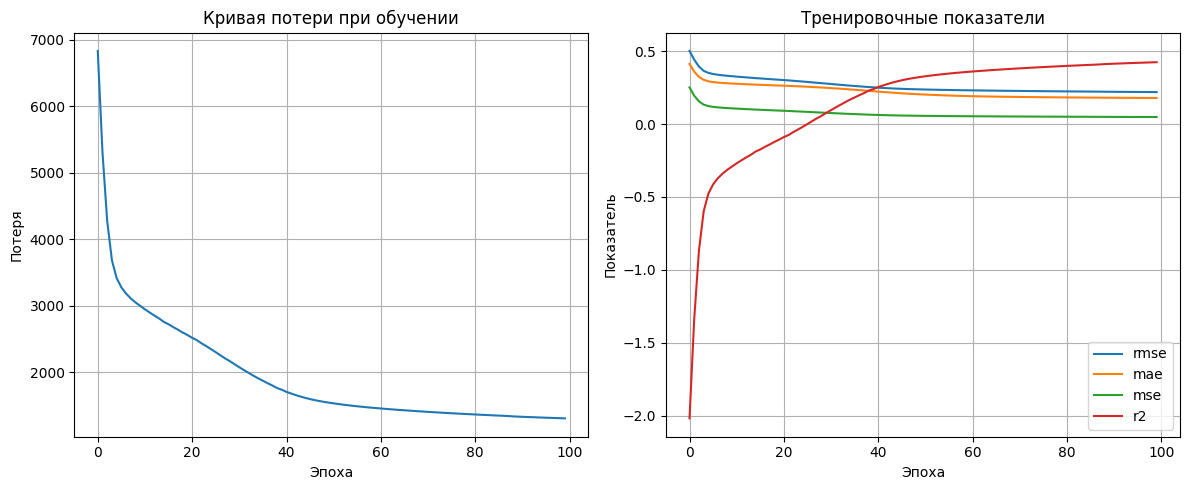

In [59]:
plot_training_history(
    train_results['train_loss'],
    titles=['Кривая потери при обучении', 'Тренировочные показатели'],
    metric_history={
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    },
)

100%|██████████| 11/11 [00:00<00:00, 628.32it/s]


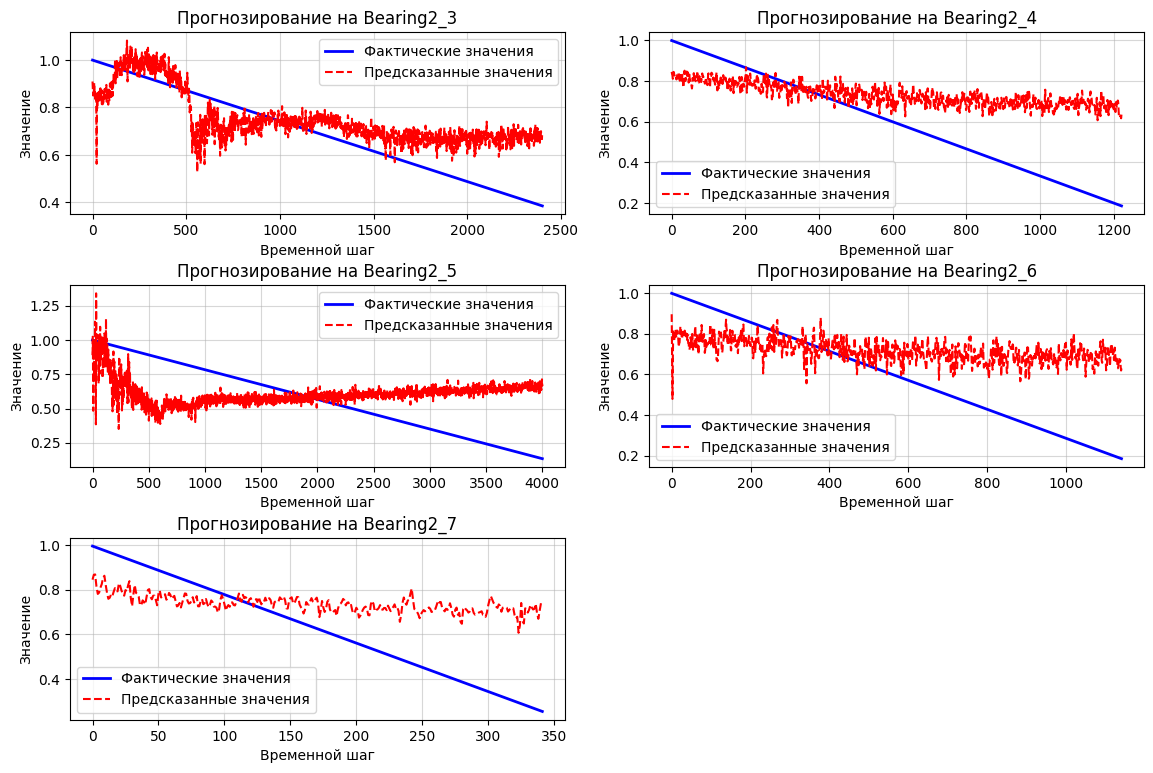

In [60]:
test_results = get_test_results(condition=2)

plot_predictions_grid(
    y_true_list=test_results['y_true_list'],
    y_pred_list=test_results['y_pred_list'],
    titles=test_results['titles'],
)

In [54]:
test_results['test_results_list']

[{'test_r2': [0.03055519127552997],
  'test_mae': [0.15120938],
  'test_mse': [0.030491496],
  'test_rmse': [0.17461814]},
 {'test_r2': [-0.11734194683050614],
  'test_mae': [0.20190245],
  'test_mse': [0.06164853],
  'test_rmse': [0.24829122]},
 {'test_r2': [-0.06330485986143164],
  'test_mae': [0.21881811],
  'test_mse': [0.06643675],
  'test_rmse': [0.25775328]},
 {'test_r2': [0.1029300822825836],
  'test_mae': [0.17658125],
  'test_mse': [0.049614064],
  'test_rmse': [0.22274216]},
 {'test_r2': [-0.07011045663566406],
  'test_mae': [0.1827371],
  'test_mse': [0.049335312],
  'test_rmse': [0.22211553]}]

### Condition 3

In [39]:
train_dataset = BearingDataset(
    df=df[0][df[0]['unit'].isin(['3_2'])],
)

val_dataset = BearingDataset(
    df=df[0][df[0]['unit'] == '3_1'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

len(train_dataset), len(val_dataset)

model = BearingCNN()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [40]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 100)

train_results

100%|██████████| 103/103 [00:00<00:00, 255.17it/s]


Epoch 1: Train Loss 11725.6375, Train R2 = -0.612, Train RMSE = 0.366, Train MSE = 0.134, Train MAE = 0.264


Epoch 1 Val: 100%|██████████| 33/33 [00:00<00:00, 506.15it/s]


Epoch 1: Val Loss 2120.9133, Val R2 = -2.011, Val RMSE = 0.500, Val MSE = 0.250, Val MAE = 0.414


100%|██████████| 103/103 [00:00<00:00, 268.96it/s]


Epoch 2: Train Loss 16678.1765, Train R2 = -0.625, Train RMSE = 0.368, Train MSE = 0.135, Train MAE = 0.279


Epoch 2 Val: 100%|██████████| 33/33 [00:00<00:00, 528.00it/s]


Epoch 2: Val Loss 3772.4380, Val R2 = -1.058, Val RMSE = 0.413, Val MSE = 0.171, Val MAE = 0.341


100%|██████████| 103/103 [00:00<00:00, 277.52it/s]


Epoch 3: Train Loss 18463.2416, Train R2 = -1.283, Train RMSE = 0.436, Train MSE = 0.190, Train MAE = 0.358


Epoch 3 Val: 100%|██████████| 33/33 [00:00<00:00, 522.41it/s]


Epoch 3: Val Loss 2784.5517, Val R2 = -0.859, Val RMSE = 0.393, Val MSE = 0.154, Val MAE = 0.322


100%|██████████| 103/103 [00:00<00:00, 267.40it/s]


Epoch 4: Train Loss 15208.4448, Train R2 = -0.901, Train RMSE = 0.398, Train MSE = 0.158, Train MAE = 0.325


Epoch 4 Val: 100%|██████████| 33/33 [00:00<00:00, 473.79it/s]


Epoch 4: Val Loss 2514.3004, Val R2 = -0.563, Val RMSE = 0.360, Val MSE = 0.130, Val MAE = 0.296


100%|██████████| 103/103 [00:00<00:00, 270.49it/s]


Epoch 5: Train Loss 12562.9478, Train R2 = -0.642, Train RMSE = 0.370, Train MSE = 0.137, Train MAE = 0.306


Epoch 5 Val: 100%|██████████| 33/33 [00:00<00:00, 506.18it/s]


Epoch 5: Val Loss 1981.8870, Val R2 = -0.366, Val RMSE = 0.337, Val MSE = 0.113, Val MAE = 0.278


100%|██████████| 103/103 [00:00<00:00, 246.23it/s]


Epoch 6: Train Loss 10337.6174, Train R2 = -0.416, Train RMSE = 0.343, Train MSE = 0.118, Train MAE = 0.288


Epoch 6 Val: 100%|██████████| 33/33 [00:00<00:00, 479.37it/s]


Epoch 6: Val Loss 1360.7415, Val R2 = -0.213, Val RMSE = 0.317, Val MSE = 0.101, Val MAE = 0.264


100%|██████████| 103/103 [00:00<00:00, 259.83it/s]


Epoch 7: Train Loss 8703.3251, Train R2 = -0.193, Train RMSE = 0.315, Train MSE = 0.099, Train MAE = 0.268


Epoch 7 Val: 100%|██████████| 33/33 [00:00<00:00, 525.87it/s]


Epoch 7: Val Loss 1181.8683, Val R2 = -0.158, Val RMSE = 0.310, Val MSE = 0.096, Val MAE = 0.258


100%|██████████| 103/103 [00:00<00:00, 263.47it/s]


Epoch 8: Train Loss 8550.5532, Train R2 = -0.132, Train RMSE = 0.307, Train MSE = 0.094, Train MAE = 0.266


Epoch 8 Val: 100%|██████████| 33/33 [00:00<00:00, 479.08it/s]


Epoch 8: Val Loss 1655.5125, Val R2 = -0.110, Val RMSE = 0.304, Val MSE = 0.092, Val MAE = 0.256


100%|██████████| 103/103 [00:00<00:00, 272.63it/s]


Epoch 9: Train Loss 9333.2894, Train R2 = -0.191, Train RMSE = 0.315, Train MSE = 0.099, Train MAE = 0.268


Epoch 9 Val: 100%|██████████| 33/33 [00:00<00:00, 387.55it/s]


Epoch 9: Val Loss 812.3338, Val R2 = -0.041, Val RMSE = 0.294, Val MSE = 0.086, Val MAE = 0.246


100%|██████████| 103/103 [00:00<00:00, 283.00it/s]


Epoch 10: Train Loss 8322.4543, Train R2 = -0.016, Train RMSE = 0.291, Train MSE = 0.085, Train MAE = 0.255


Epoch 10 Val: 100%|██████████| 33/33 [00:00<00:00, 564.10it/s]


Epoch 10: Val Loss 2211.8895, Val R2 = -0.129, Val RMSE = 0.306, Val MSE = 0.094, Val MAE = 0.259


100%|██████████| 103/103 [00:00<00:00, 259.91it/s]


Epoch 11: Train Loss 9037.8485, Train R2 = -0.235, Train RMSE = 0.321, Train MSE = 0.103, Train MAE = 0.271


Epoch 11 Val: 100%|██████████| 33/33 [00:00<00:00, 546.77it/s]


Epoch 11: Val Loss 927.4601, Val R2 = -0.045, Val RMSE = 0.295, Val MSE = 0.087, Val MAE = 0.247


100%|██████████| 103/103 [00:00<00:00, 256.05it/s]


Epoch 12: Train Loss 7693.7789, Train R2 = -0.055, Train RMSE = 0.296, Train MSE = 0.088, Train MAE = 0.257


Epoch 12 Val: 100%|██████████| 33/33 [00:00<00:00, 487.33it/s]


Epoch 12: Val Loss 1119.3920, Val R2 = -0.006, Val RMSE = 0.289, Val MSE = 0.084, Val MAE = 0.245


100%|██████████| 103/103 [00:00<00:00, 240.85it/s]


Epoch 13: Train Loss 7565.3716, Train R2 = -0.036, Train RMSE = 0.294, Train MSE = 0.086, Train MAE = 0.255


Epoch 13 Val: 100%|██████████| 33/33 [00:00<00:00, 514.38it/s]


Epoch 13: Val Loss 896.6405, Val R2 = 0.025, Val RMSE = 0.285, Val MSE = 0.081, Val MAE = 0.241


100%|██████████| 103/103 [00:00<00:00, 240.12it/s]


Epoch 14: Train Loss 7190.4402, Train R2 = 0.012, Train RMSE = 0.287, Train MSE = 0.082, Train MAE = 0.251


Epoch 14 Val: 100%|██████████| 33/33 [00:00<00:00, 521.20it/s]


Epoch 14: Val Loss 982.8971, Val R2 = 0.029, Val RMSE = 0.284, Val MSE = 0.081, Val MAE = 0.241


100%|██████████| 103/103 [00:00<00:00, 249.16it/s]


Epoch 15: Train Loss 7237.3916, Train R2 = 0.010, Train RMSE = 0.287, Train MSE = 0.082, Train MAE = 0.250


Epoch 15 Val: 100%|██████████| 33/33 [00:00<00:00, 477.35it/s]


Epoch 15: Val Loss 843.9128, Val R2 = 0.042, Val RMSE = 0.282, Val MSE = 0.080, Val MAE = 0.239


100%|██████████| 103/103 [00:00<00:00, 258.31it/s]


Epoch 16: Train Loss 6911.7001, Train R2 = 0.050, Train RMSE = 0.281, Train MSE = 0.079, Train MAE = 0.246


Epoch 16 Val: 100%|██████████| 33/33 [00:00<00:00, 502.57it/s]


Epoch 16: Val Loss 945.9120, Val R2 = 0.021, Val RMSE = 0.285, Val MSE = 0.081, Val MAE = 0.241


100%|██████████| 103/103 [00:00<00:00, 257.74it/s]


Epoch 17: Train Loss 7168.6717, Train R2 = 0.027, Train RMSE = 0.285, Train MSE = 0.081, Train MAE = 0.248


Epoch 17 Val: 100%|██████████| 33/33 [00:00<00:00, 532.19it/s]


Epoch 17: Val Loss 767.0630, Val R2 = 0.058, Val RMSE = 0.280, Val MSE = 0.078, Val MAE = 0.237


100%|██████████| 103/103 [00:00<00:00, 257.58it/s]


Epoch 18: Train Loss 6779.0145, Train R2 = 0.089, Train RMSE = 0.275, Train MSE = 0.076, Train MAE = 0.243


Epoch 18 Val: 100%|██████████| 33/33 [00:00<00:00, 496.08it/s]


Epoch 18: Val Loss 1075.1558, Val R2 = 0.049, Val RMSE = 0.281, Val MSE = 0.079, Val MAE = 0.239


100%|██████████| 103/103 [00:00<00:00, 266.99it/s]


Epoch 19: Train Loss 7445.7616, Train R2 = 0.028, Train RMSE = 0.284, Train MSE = 0.081, Train MAE = 0.246


Epoch 19 Val: 100%|██████████| 33/33 [00:00<00:00, 474.14it/s]


Epoch 19: Val Loss 645.5606, Val R2 = 0.099, Val RMSE = 0.274, Val MSE = 0.075, Val MAE = 0.231


100%|██████████| 103/103 [00:00<00:00, 258.42it/s]


Epoch 20: Train Loss 6626.9191, Train R2 = 0.158, Train RMSE = 0.265, Train MSE = 0.070, Train MAE = 0.236


Epoch 20 Val: 100%|██████████| 33/33 [00:00<00:00, 505.55it/s]


Epoch 20: Val Loss 1319.4047, Val R2 = 0.058, Val RMSE = 0.280, Val MSE = 0.078, Val MAE = 0.239


100%|██████████| 103/103 [00:00<00:00, 254.07it/s]


Epoch 21: Train Loss 7367.1005, Train R2 = 0.002, Train RMSE = 0.288, Train MSE = 0.083, Train MAE = 0.247


Epoch 21 Val: 100%|██████████| 33/33 [00:00<00:00, 509.85it/s]


Epoch 21: Val Loss 651.0475, Val R2 = 0.138, Val RMSE = 0.268, Val MSE = 0.072, Val MAE = 0.228


100%|██████████| 103/103 [00:00<00:00, 245.79it/s]


Epoch 22: Train Loss 5545.8135, Train R2 = 0.238, Train RMSE = 0.252, Train MSE = 0.063, Train MAE = 0.221


Epoch 22 Val: 100%|██████████| 33/33 [00:00<00:00, 512.13it/s]


Epoch 22: Val Loss 718.1396, Val R2 = 0.099, Val RMSE = 0.274, Val MSE = 0.075, Val MAE = 0.232


100%|██████████| 103/103 [00:00<00:00, 258.63it/s]


Epoch 23: Train Loss 6041.9233, Train R2 = 0.185, Train RMSE = 0.261, Train MSE = 0.068, Train MAE = 0.224


Epoch 23 Val: 100%|██████████| 33/33 [00:00<00:00, 505.88it/s]


Epoch 23: Val Loss 583.9761, Val R2 = 0.178, Val RMSE = 0.261, Val MSE = 0.068, Val MAE = 0.222


100%|██████████| 103/103 [00:00<00:00, 245.40it/s]


Epoch 24: Train Loss 5159.5666, Train R2 = 0.310, Train RMSE = 0.240, Train MSE = 0.057, Train MAE = 0.210


Epoch 24 Val: 100%|██████████| 33/33 [00:00<00:00, 419.25it/s]


Epoch 24: Val Loss 759.4991, Val R2 = 0.107, Val RMSE = 0.272, Val MSE = 0.074, Val MAE = 0.231


100%|██████████| 103/103 [00:00<00:00, 258.90it/s]


Epoch 25: Train Loss 6211.6824, Train R2 = 0.158, Train RMSE = 0.265, Train MSE = 0.070, Train MAE = 0.224


Epoch 25 Val: 100%|██████████| 33/33 [00:00<00:00, 478.77it/s]


Epoch 25: Val Loss 539.7212, Val R2 = 0.234, Val RMSE = 0.252, Val MSE = 0.064, Val MAE = 0.215


100%|██████████| 103/103 [00:00<00:00, 249.90it/s]


Epoch 26: Train Loss 4488.2663, Train R2 = 0.396, Train RMSE = 0.224, Train MSE = 0.050, Train MAE = 0.194


Epoch 26 Val: 100%|██████████| 33/33 [00:00<00:00, 521.18it/s]


Epoch 26: Val Loss 599.6310, Val R2 = 0.180, Val RMSE = 0.261, Val MSE = 0.068, Val MAE = 0.221


100%|██████████| 103/103 [00:00<00:00, 237.10it/s]


Epoch 27: Train Loss 5661.2805, Train R2 = 0.260, Train RMSE = 0.248, Train MSE = 0.062, Train MAE = 0.204


Epoch 27 Val: 100%|██████████| 33/33 [00:00<00:00, 506.29it/s]


Epoch 27: Val Loss 524.0482, Val R2 = 0.316, Val RMSE = 0.238, Val MSE = 0.057, Val MAE = 0.205


100%|██████████| 103/103 [00:00<00:00, 246.85it/s]


Epoch 28: Train Loss 4500.9539, Train R2 = 0.488, Train RMSE = 0.206, Train MSE = 0.043, Train MAE = 0.185


Epoch 28 Val: 100%|██████████| 33/33 [00:00<00:00, 518.89it/s]


Epoch 28: Val Loss 976.9964, Val R2 = 0.249, Val RMSE = 0.250, Val MSE = 0.062, Val MAE = 0.217


100%|██████████| 103/103 [00:00<00:00, 252.21it/s]


Epoch 29: Train Loss 6492.4190, Train R2 = 0.109, Train RMSE = 0.272, Train MSE = 0.074, Train MAE = 0.227


Epoch 29 Val: 100%|██████████| 33/33 [00:00<00:00, 395.75it/s]


Epoch 29: Val Loss 458.7603, Val R2 = 0.383, Val RMSE = 0.226, Val MSE = 0.051, Val MAE = 0.197


100%|██████████| 103/103 [00:00<00:00, 259.35it/s]


Epoch 30: Train Loss 3685.5515, Train R2 = 0.496, Train RMSE = 0.205, Train MSE = 0.042, Train MAE = 0.172


Epoch 30 Val: 100%|██████████| 33/33 [00:00<00:00, 471.13it/s]


Epoch 30: Val Loss 422.2342, Val R2 = 0.411, Val RMSE = 0.221, Val MSE = 0.049, Val MAE = 0.190


100%|██████████| 103/103 [00:00<00:00, 243.36it/s]


Epoch 31: Train Loss 3183.6953, Train R2 = 0.565, Train RMSE = 0.190, Train MSE = 0.036, Train MAE = 0.159


Epoch 31 Val: 100%|██████████| 33/33 [00:00<00:00, 494.51it/s]


Epoch 31: Val Loss 430.7238, Val R2 = 0.416, Val RMSE = 0.220, Val MSE = 0.049, Val MAE = 0.187


100%|██████████| 103/103 [00:00<00:00, 253.91it/s]


Epoch 32: Train Loss 3169.4673, Train R2 = 0.566, Train RMSE = 0.190, Train MSE = 0.036, Train MAE = 0.156


Epoch 32 Val: 100%|██████████| 33/33 [00:00<00:00, 498.33it/s]


Epoch 32: Val Loss 394.4077, Val R2 = 0.497, Val RMSE = 0.204, Val MSE = 0.042, Val MAE = 0.173


100%|██████████| 103/103 [00:00<00:00, 239.20it/s]


Epoch 33: Train Loss 2415.9395, Train R2 = 0.679, Train RMSE = 0.164, Train MSE = 0.027, Train MAE = 0.133


Epoch 33 Val: 100%|██████████| 33/33 [00:00<00:00, 416.77it/s]


Epoch 33: Val Loss 370.8827, Val R2 = 0.488, Val RMSE = 0.206, Val MSE = 0.042, Val MAE = 0.171


100%|██████████| 103/103 [00:00<00:00, 246.64it/s]


Epoch 34: Train Loss 3072.2431, Train R2 = 0.590, Train RMSE = 0.185, Train MSE = 0.034, Train MAE = 0.147


Epoch 34 Val: 100%|██████████| 33/33 [00:00<00:00, 474.35it/s]


Epoch 34: Val Loss 335.3485, Val R2 = 0.575, Val RMSE = 0.188, Val MSE = 0.035, Val MAE = 0.158


100%|██████████| 103/103 [00:00<00:00, 260.58it/s]


Epoch 35: Train Loss 2263.6325, Train R2 = 0.733, Train RMSE = 0.149, Train MSE = 0.022, Train MAE = 0.121


Epoch 35 Val: 100%|██████████| 33/33 [00:00<00:00, 462.16it/s]


Epoch 35: Val Loss 353.2997, Val R2 = 0.507, Val RMSE = 0.202, Val MSE = 0.041, Val MAE = 0.167


100%|██████████| 103/103 [00:00<00:00, 235.83it/s]


Epoch 36: Train Loss 4120.1627, Train R2 = 0.454, Train RMSE = 0.213, Train MSE = 0.045, Train MAE = 0.166


Epoch 36 Val: 100%|██████████| 33/33 [00:00<00:00, 478.57it/s]


Epoch 36: Val Loss 306.3503, Val R2 = 0.604, Val RMSE = 0.181, Val MSE = 0.033, Val MAE = 0.153


100%|██████████| 103/103 [00:00<00:00, 256.89it/s]


Epoch 37: Train Loss 2371.0454, Train R2 = 0.711, Train RMSE = 0.155, Train MSE = 0.024, Train MAE = 0.126


Epoch 37 Val: 100%|██████████| 33/33 [00:00<00:00, 515.53it/s]


Epoch 37: Val Loss 323.6783, Val R2 = 0.568, Val RMSE = 0.189, Val MSE = 0.036, Val MAE = 0.160


100%|██████████| 103/103 [00:00<00:00, 242.42it/s]


Epoch 38: Train Loss 3801.0234, Train R2 = 0.488, Train RMSE = 0.207, Train MSE = 0.043, Train MAE = 0.161


Epoch 38 Val: 100%|██████████| 33/33 [00:00<00:00, 500.28it/s]


Epoch 38: Val Loss 286.6537, Val R2 = 0.629, Val RMSE = 0.175, Val MSE = 0.031, Val MAE = 0.151


100%|██████████| 103/103 [00:00<00:00, 251.36it/s]


Epoch 39: Train Loss 2317.4840, Train R2 = 0.696, Train RMSE = 0.159, Train MSE = 0.025, Train MAE = 0.128


Epoch 39 Val: 100%|██████████| 33/33 [00:00<00:00, 468.66it/s]


Epoch 39: Val Loss 274.1930, Val R2 = 0.616, Val RMSE = 0.178, Val MSE = 0.032, Val MAE = 0.153


100%|██████████| 103/103 [00:00<00:00, 228.62it/s]


Epoch 40: Train Loss 3107.3929, Train R2 = 0.576, Train RMSE = 0.188, Train MSE = 0.035, Train MAE = 0.146


Epoch 40 Val: 100%|██████████| 33/33 [00:00<00:00, 516.38it/s]


Epoch 40: Val Loss 272.7404, Val R2 = 0.646, Val RMSE = 0.171, Val MSE = 0.029, Val MAE = 0.149


100%|██████████| 103/103 [00:00<00:00, 238.57it/s]


Epoch 41: Train Loss 2341.5505, Train R2 = 0.685, Train RMSE = 0.162, Train MSE = 0.026, Train MAE = 0.128


Epoch 41 Val: 100%|██████████| 33/33 [00:00<00:00, 497.14it/s]


Epoch 41: Val Loss 252.8400, Val R2 = 0.643, Val RMSE = 0.172, Val MSE = 0.030, Val MAE = 0.150


100%|██████████| 103/103 [00:00<00:00, 233.32it/s]


Epoch 42: Train Loss 2777.0714, Train R2 = 0.622, Train RMSE = 0.177, Train MSE = 0.031, Train MAE = 0.138


Epoch 42 Val: 100%|██████████| 33/33 [00:00<00:00, 477.71it/s]


Epoch 42: Val Loss 256.0582, Val R2 = 0.661, Val RMSE = 0.168, Val MSE = 0.028, Val MAE = 0.146


100%|██████████| 103/103 [00:00<00:00, 253.27it/s]


Epoch 43: Train Loss 2209.9220, Train R2 = 0.706, Train RMSE = 0.156, Train MSE = 0.024, Train MAE = 0.123


Epoch 43 Val: 100%|██████████| 33/33 [00:00<00:00, 498.85it/s]


Epoch 43: Val Loss 241.5176, Val R2 = 0.658, Val RMSE = 0.169, Val MSE = 0.028, Val MAE = 0.147


100%|██████████| 103/103 [00:00<00:00, 251.03it/s]


Epoch 44: Train Loss 2736.3076, Train R2 = 0.630, Train RMSE = 0.176, Train MSE = 0.031, Train MAE = 0.136


Epoch 44 Val: 100%|██████████| 33/33 [00:00<00:00, 491.36it/s]


Epoch 44: Val Loss 245.3728, Val R2 = 0.672, Val RMSE = 0.165, Val MSE = 0.027, Val MAE = 0.144


100%|██████████| 103/103 [00:00<00:00, 248.52it/s]


Epoch 45: Train Loss 2098.0734, Train R2 = 0.728, Train RMSE = 0.151, Train MSE = 0.023, Train MAE = 0.119


Epoch 45 Val: 100%|██████████| 33/33 [00:00<00:00, 480.91it/s]


Epoch 45: Val Loss 237.7879, Val R2 = 0.669, Val RMSE = 0.166, Val MSE = 0.028, Val MAE = 0.145


100%|██████████| 103/103 [00:00<00:00, 256.46it/s]


Epoch 46: Train Loss 2821.2309, Train R2 = 0.624, Train RMSE = 0.177, Train MSE = 0.031, Train MAE = 0.136


Epoch 46 Val: 100%|██████████| 33/33 [00:00<00:00, 512.94it/s]


Epoch 46: Val Loss 235.0824, Val R2 = 0.683, Val RMSE = 0.162, Val MSE = 0.026, Val MAE = 0.141


100%|██████████| 103/103 [00:00<00:00, 233.76it/s]


Epoch 47: Train Loss 2007.9203, Train R2 = 0.754, Train RMSE = 0.143, Train MSE = 0.020, Train MAE = 0.115


Epoch 47 Val: 100%|██████████| 33/33 [00:00<00:00, 481.33it/s]


Epoch 47: Val Loss 253.4391, Val R2 = 0.678, Val RMSE = 0.164, Val MSE = 0.027, Val MAE = 0.143


100%|██████████| 103/103 [00:00<00:00, 259.91it/s]


Epoch 48: Train Loss 2949.3545, Train R2 = 0.606, Train RMSE = 0.181, Train MSE = 0.033, Train MAE = 0.138


Epoch 48 Val: 100%|██████████| 33/33 [00:00<00:00, 513.48it/s]


Epoch 48: Val Loss 227.2344, Val R2 = 0.686, Val RMSE = 0.161, Val MSE = 0.026, Val MAE = 0.140


100%|██████████| 103/103 [00:00<00:00, 233.93it/s]


Epoch 49: Train Loss 1981.4150, Train R2 = 0.755, Train RMSE = 0.143, Train MSE = 0.020, Train MAE = 0.114


Epoch 49 Val: 100%|██████████| 33/33 [00:00<00:00, 508.01it/s]


Epoch 49: Val Loss 258.8468, Val R2 = 0.688, Val RMSE = 0.161, Val MSE = 0.026, Val MAE = 0.140


100%|██████████| 103/103 [00:00<00:00, 251.48it/s]


Epoch 50: Train Loss 2724.5141, Train R2 = 0.635, Train RMSE = 0.174, Train MSE = 0.030, Train MAE = 0.133


Epoch 50 Val: 100%|██████████| 33/33 [00:00<00:00, 431.17it/s]


Epoch 50: Val Loss 225.7471, Val R2 = 0.688, Val RMSE = 0.161, Val MSE = 0.026, Val MAE = 0.138


100%|██████████| 103/103 [00:00<00:00, 242.95it/s]


Epoch 51: Train Loss 1880.1724, Train R2 = 0.761, Train RMSE = 0.141, Train MSE = 0.020, Train MAE = 0.112


Epoch 51 Val: 100%|██████████| 33/33 [00:00<00:00, 499.43it/s]


Epoch 51: Val Loss 242.3210, Val R2 = 0.695, Val RMSE = 0.159, Val MSE = 0.025, Val MAE = 0.137


100%|██████████| 103/103 [00:00<00:00, 256.79it/s]


Epoch 52: Train Loss 2478.8988, Train R2 = 0.666, Train RMSE = 0.167, Train MSE = 0.028, Train MAE = 0.128


Epoch 52 Val: 100%|██████████| 33/33 [00:00<00:00, 498.41it/s]


Epoch 52: Val Loss 218.9487, Val R2 = 0.691, Val RMSE = 0.160, Val MSE = 0.026, Val MAE = 0.136


100%|██████████| 103/103 [00:00<00:00, 276.03it/s]


Epoch 53: Train Loss 1776.2249, Train R2 = 0.771, Train RMSE = 0.138, Train MSE = 0.019, Train MAE = 0.109


Epoch 53 Val: 100%|██████████| 33/33 [00:00<00:00, 513.19it/s]


Epoch 53: Val Loss 241.6956, Val R2 = 0.701, Val RMSE = 0.158, Val MSE = 0.025, Val MAE = 0.134


100%|██████████| 103/103 [00:00<00:00, 249.34it/s]


Epoch 54: Train Loss 2248.0505, Train R2 = 0.697, Train RMSE = 0.159, Train MSE = 0.025, Train MAE = 0.121


Epoch 54 Val: 100%|██████████| 33/33 [00:00<00:00, 516.60it/s]


Epoch 54: Val Loss 218.9242, Val R2 = 0.690, Val RMSE = 0.161, Val MSE = 0.026, Val MAE = 0.135


100%|██████████| 103/103 [00:00<00:00, 254.47it/s]


Epoch 55: Train Loss 1659.6577, Train R2 = 0.785, Train RMSE = 0.134, Train MSE = 0.018, Train MAE = 0.104


Epoch 55 Val: 100%|██████████| 33/33 [00:00<00:00, 525.73it/s]


Epoch 55: Val Loss 244.6460, Val R2 = 0.705, Val RMSE = 0.157, Val MSE = 0.025, Val MAE = 0.132


100%|██████████| 103/103 [00:00<00:00, 255.21it/s]


Epoch 56: Train Loss 2060.2050, Train R2 = 0.723, Train RMSE = 0.152, Train MSE = 0.023, Train MAE = 0.115


Epoch 56 Val: 100%|██████████| 33/33 [00:00<00:00, 463.19it/s]


Epoch 56: Val Loss 223.1945, Val R2 = 0.686, Val RMSE = 0.161, Val MSE = 0.026, Val MAE = 0.134


100%|██████████| 103/103 [00:00<00:00, 252.45it/s]


Epoch 57: Train Loss 1530.9284, Train R2 = 0.805, Train RMSE = 0.127, Train MSE = 0.016, Train MAE = 0.099


Epoch 57 Val: 100%|██████████| 33/33 [00:00<00:00, 402.99it/s]


Epoch 57: Val Loss 263.7172, Val R2 = 0.708, Val RMSE = 0.156, Val MSE = 0.024, Val MAE = 0.130


100%|██████████| 103/103 [00:00<00:00, 254.23it/s]


Epoch 58: Train Loss 1951.0822, Train R2 = 0.741, Train RMSE = 0.147, Train MSE = 0.022, Train MAE = 0.110


Epoch 58 Val: 100%|██████████| 33/33 [00:00<00:00, 538.59it/s]


Epoch 58: Val Loss 232.9975, Val R2 = 0.676, Val RMSE = 0.164, Val MSE = 0.027, Val MAE = 0.135


100%|██████████| 103/103 [00:00<00:00, 242.14it/s]


Epoch 59: Train Loss 1411.1740, Train R2 = 0.826, Train RMSE = 0.120, Train MSE = 0.014, Train MAE = 0.093


Epoch 59 Val: 100%|██████████| 33/33 [00:00<00:00, 496.47it/s]


Epoch 59: Val Loss 299.8634, Val R2 = 0.710, Val RMSE = 0.155, Val MSE = 0.024, Val MAE = 0.129


100%|██████████| 103/103 [00:00<00:00, 234.89it/s]


Epoch 60: Train Loss 1820.5273, Train R2 = 0.759, Train RMSE = 0.142, Train MSE = 0.020, Train MAE = 0.105


Epoch 60 Val: 100%|██████████| 33/33 [00:00<00:00, 483.21it/s]


Epoch 60: Val Loss 250.3742, Val R2 = 0.663, Val RMSE = 0.167, Val MSE = 0.028, Val MAE = 0.136


100%|██████████| 103/103 [00:00<00:00, 243.61it/s]


Epoch 61: Train Loss 1285.8308, Train R2 = 0.843, Train RMSE = 0.114, Train MSE = 0.013, Train MAE = 0.088


Epoch 61 Val: 100%|██████████| 33/33 [00:00<00:00, 500.70it/s]


Epoch 61: Val Loss 328.6544, Val R2 = 0.706, Val RMSE = 0.156, Val MSE = 0.024, Val MAE = 0.128


100%|██████████| 103/103 [00:00<00:00, 258.25it/s]


Epoch 62: Train Loss 1705.0876, Train R2 = 0.775, Train RMSE = 0.137, Train MSE = 0.019, Train MAE = 0.101


Epoch 62 Val: 100%|██████████| 33/33 [00:00<00:00, 508.25it/s]


Epoch 62: Val Loss 266.4901, Val R2 = 0.643, Val RMSE = 0.172, Val MSE = 0.030, Val MAE = 0.138


100%|██████████| 103/103 [00:00<00:00, 251.48it/s]


Epoch 63: Train Loss 1189.0766, Train R2 = 0.858, Train RMSE = 0.109, Train MSE = 0.012, Train MAE = 0.083


Epoch 63 Val: 100%|██████████| 33/33 [00:00<00:00, 519.71it/s]


Epoch 63: Val Loss 355.1788, Val R2 = 0.696, Val RMSE = 0.159, Val MSE = 0.025, Val MAE = 0.128


100%|██████████| 103/103 [00:00<00:00, 258.43it/s]


Epoch 64: Train Loss 1560.4530, Train R2 = 0.796, Train RMSE = 0.130, Train MSE = 0.017, Train MAE = 0.096


Epoch 64 Val: 100%|██████████| 33/33 [00:00<00:00, 440.29it/s]


Epoch 64: Val Loss 286.8987, Val R2 = 0.625, Val RMSE = 0.177, Val MSE = 0.031, Val MAE = 0.141


100%|██████████| 103/103 [00:00<00:00, 229.40it/s]


Epoch 65: Train Loss 1051.6949, Train R2 = 0.877, Train RMSE = 0.101, Train MSE = 0.010, Train MAE = 0.078


Epoch 65 Val: 100%|██████████| 33/33 [00:00<00:00, 400.05it/s]


Epoch 65: Val Loss 389.4814, Val R2 = 0.689, Val RMSE = 0.161, Val MSE = 0.026, Val MAE = 0.128


100%|██████████| 103/103 [00:00<00:00, 241.12it/s]


Epoch 66: Train Loss 1447.4308, Train R2 = 0.811, Train RMSE = 0.125, Train MSE = 0.016, Train MAE = 0.092


Epoch 66 Val: 100%|██████████| 33/33 [00:00<00:00, 527.84it/s]


Epoch 66: Val Loss 302.0447, Val R2 = 0.604, Val RMSE = 0.181, Val MSE = 0.033, Val MAE = 0.144


100%|██████████| 103/103 [00:00<00:00, 243.48it/s]


Epoch 67: Train Loss 952.0619, Train R2 = 0.890, Train RMSE = 0.095, Train MSE = 0.009, Train MAE = 0.073


Epoch 67 Val: 100%|██████████| 33/33 [00:00<00:00, 510.31it/s]


Epoch 67: Val Loss 408.2463, Val R2 = 0.669, Val RMSE = 0.166, Val MSE = 0.027, Val MAE = 0.131


100%|██████████| 103/103 [00:00<00:00, 248.32it/s]


Epoch 68: Train Loss 1291.2839, Train R2 = 0.832, Train RMSE = 0.118, Train MSE = 0.014, Train MAE = 0.087


Epoch 68 Val: 100%|██████████| 33/33 [00:00<00:00, 479.48it/s]


Epoch 68: Val Loss 330.3131, Val R2 = 0.578, Val RMSE = 0.187, Val MSE = 0.035, Val MAE = 0.149


100%|██████████| 103/103 [00:00<00:00, 242.56it/s]


Epoch 69: Train Loss 820.0513, Train R2 = 0.905, Train RMSE = 0.089, Train MSE = 0.008, Train MAE = 0.069


Epoch 69 Val: 100%|██████████| 33/33 [00:00<00:00, 509.74it/s]


Epoch 69: Val Loss 441.1506, Val R2 = 0.651, Val RMSE = 0.170, Val MSE = 0.029, Val MAE = 0.135


100%|██████████| 103/103 [00:00<00:00, 249.43it/s]


Epoch 70: Train Loss 1161.1596, Train R2 = 0.850, Train RMSE = 0.112, Train MSE = 0.012, Train MAE = 0.083


Epoch 70 Val: 100%|██████████| 33/33 [00:00<00:00, 471.70it/s]


Epoch 70: Val Loss 347.1091, Val R2 = 0.557, Val RMSE = 0.192, Val MSE = 0.037, Val MAE = 0.153


100%|██████████| 103/103 [00:00<00:00, 251.72it/s]


Epoch 71: Train Loss 740.7615, Train R2 = 0.917, Train RMSE = 0.083, Train MSE = 0.007, Train MAE = 0.065


Epoch 71 Val: 100%|██████████| 33/33 [00:00<00:00, 470.74it/s]


Epoch 71: Val Loss 458.4066, Val R2 = 0.639, Val RMSE = 0.173, Val MSE = 0.030, Val MAE = 0.138


100%|██████████| 103/103 [00:00<00:00, 252.21it/s]


Epoch 72: Train Loss 1058.2224, Train R2 = 0.865, Train RMSE = 0.106, Train MSE = 0.011, Train MAE = 0.079


Epoch 72 Val: 100%|██████████| 33/33 [00:00<00:00, 511.67it/s]


Epoch 72: Val Loss 374.3208, Val R2 = 0.525, Val RMSE = 0.199, Val MSE = 0.039, Val MAE = 0.159


100%|██████████| 103/103 [00:00<00:00, 243.77it/s]


Epoch 73: Train Loss 647.1837, Train R2 = 0.930, Train RMSE = 0.076, Train MSE = 0.006, Train MAE = 0.060


Epoch 73 Val: 100%|██████████| 33/33 [00:00<00:00, 392.45it/s]


Epoch 73: Val Loss 497.5892, Val R2 = 0.621, Val RMSE = 0.177, Val MSE = 0.031, Val MAE = 0.142


100%|██████████| 103/103 [00:00<00:00, 242.72it/s]


Epoch 74: Train Loss 951.4447, Train R2 = 0.879, Train RMSE = 0.100, Train MSE = 0.010, Train MAE = 0.075


Epoch 74 Val: 100%|██████████| 33/33 [00:00<00:00, 482.00it/s]


Epoch 74: Val Loss 394.0342, Val R2 = 0.499, Val RMSE = 0.204, Val MSE = 0.042, Val MAE = 0.164


100%|██████████| 103/103 [00:00<00:00, 231.85it/s]


Epoch 75: Train Loss 588.4813, Train R2 = 0.937, Train RMSE = 0.072, Train MSE = 0.005, Train MAE = 0.057


Epoch 75 Val: 100%|██████████| 33/33 [00:00<00:00, 477.34it/s]


Epoch 75: Val Loss 515.4743, Val R2 = 0.608, Val RMSE = 0.180, Val MSE = 0.033, Val MAE = 0.146


100%|██████████| 103/103 [00:00<00:00, 254.94it/s]


Epoch 76: Train Loss 827.3330, Train R2 = 0.896, Train RMSE = 0.093, Train MSE = 0.009, Train MAE = 0.071


Epoch 76 Val: 100%|██████████| 33/33 [00:00<00:00, 501.55it/s]


Epoch 76: Val Loss 420.3455, Val R2 = 0.471, Val RMSE = 0.210, Val MSE = 0.044, Val MAE = 0.171


100%|██████████| 103/103 [00:00<00:00, 260.32it/s]


Epoch 77: Train Loss 545.8313, Train R2 = 0.942, Train RMSE = 0.070, Train MSE = 0.005, Train MAE = 0.055


Epoch 77 Val: 100%|██████████| 33/33 [00:00<00:00, 504.73it/s]


Epoch 77: Val Loss 523.2327, Val R2 = 0.588, Val RMSE = 0.185, Val MSE = 0.034, Val MAE = 0.151


100%|██████████| 103/103 [00:00<00:00, 256.19it/s]


Epoch 78: Train Loss 741.7362, Train R2 = 0.908, Train RMSE = 0.088, Train MSE = 0.008, Train MAE = 0.067


Epoch 78 Val: 100%|██████████| 33/33 [00:00<00:00, 520.13it/s]


Epoch 78: Val Loss 455.3830, Val R2 = 0.414, Val RMSE = 0.221, Val MSE = 0.049, Val MAE = 0.183


100%|██████████| 103/103 [00:00<00:00, 249.78it/s]


Epoch 79: Train Loss 483.4249, Train R2 = 0.950, Train RMSE = 0.065, Train MSE = 0.004, Train MAE = 0.051


Epoch 79 Val: 100%|██████████| 33/33 [00:00<00:00, 478.40it/s]


Epoch 79: Val Loss 521.8390, Val R2 = 0.590, Val RMSE = 0.184, Val MSE = 0.034, Val MAE = 0.150


100%|██████████| 103/103 [00:00<00:00, 252.37it/s]


Epoch 80: Train Loss 637.1040, Train R2 = 0.920, Train RMSE = 0.081, Train MSE = 0.007, Train MAE = 0.063


Epoch 80 Val: 100%|██████████| 33/33 [00:00<00:00, 493.21it/s]


Epoch 80: Val Loss 491.6315, Val R2 = 0.373, Val RMSE = 0.228, Val MSE = 0.052, Val MAE = 0.194


100%|██████████| 103/103 [00:00<00:00, 262.09it/s]


Epoch 81: Train Loss 461.1820, Train R2 = 0.948, Train RMSE = 0.066, Train MSE = 0.004, Train MAE = 0.052


Epoch 81 Val: 100%|██████████| 33/33 [00:00<00:00, 524.13it/s]


Epoch 81: Val Loss 505.1387, Val R2 = 0.581, Val RMSE = 0.187, Val MSE = 0.035, Val MAE = 0.150


100%|██████████| 103/103 [00:00<00:00, 247.51it/s]


Epoch 82: Train Loss 525.5663, Train R2 = 0.933, Train RMSE = 0.075, Train MSE = 0.006, Train MAE = 0.058


Epoch 82 Val: 100%|██████████| 33/33 [00:00<00:00, 397.58it/s]


Epoch 82: Val Loss 547.7117, Val R2 = 0.310, Val RMSE = 0.239, Val MSE = 0.057, Val MAE = 0.211


100%|██████████| 103/103 [00:00<00:00, 237.16it/s]


Epoch 83: Train Loss 487.5444, Train R2 = 0.938, Train RMSE = 0.072, Train MSE = 0.005, Train MAE = 0.056


Epoch 83 Val: 100%|██████████| 33/33 [00:00<00:00, 502.21it/s]


Epoch 83: Val Loss 480.2590, Val R2 = 0.572, Val RMSE = 0.189, Val MSE = 0.036, Val MAE = 0.150


100%|██████████| 103/103 [00:00<00:00, 250.81it/s]


Epoch 84: Train Loss 443.0614, Train R2 = 0.941, Train RMSE = 0.070, Train MSE = 0.005, Train MAE = 0.055


Epoch 84 Val: 100%|██████████| 33/33 [00:00<00:00, 498.80it/s]


Epoch 84: Val Loss 589.8455, Val R2 = 0.269, Val RMSE = 0.246, Val MSE = 0.061, Val MAE = 0.222


100%|██████████| 103/103 [00:00<00:00, 245.28it/s]


Epoch 85: Train Loss 599.4250, Train R2 = 0.918, Train RMSE = 0.083, Train MSE = 0.007, Train MAE = 0.063


Epoch 85 Val: 100%|██████████| 33/33 [00:00<00:00, 504.26it/s]


Epoch 85: Val Loss 466.8677, Val R2 = 0.532, Val RMSE = 0.197, Val MSE = 0.039, Val MAE = 0.164


100%|██████████| 103/103 [00:00<00:00, 225.70it/s]


Epoch 86: Train Loss 483.1110, Train R2 = 0.937, Train RMSE = 0.073, Train MSE = 0.005, Train MAE = 0.055


Epoch 86 Val: 100%|██████████| 33/33 [00:00<00:00, 444.26it/s]


Epoch 86: Val Loss 584.9767, Val R2 = 0.306, Val RMSE = 0.240, Val MSE = 0.058, Val MAE = 0.213


100%|██████████| 103/103 [00:00<00:00, 256.04it/s]


Epoch 87: Train Loss 1041.8964, Train R2 = 0.878, Train RMSE = 0.101, Train MSE = 0.010, Train MAE = 0.075


Epoch 87 Val: 100%|██████████| 33/33 [00:00<00:00, 518.96it/s]


Epoch 87: Val Loss 420.9306, Val R2 = 0.446, Val RMSE = 0.214, Val MSE = 0.046, Val MAE = 0.178


100%|██████████| 103/103 [00:00<00:00, 242.65it/s]


Epoch 88: Train Loss 788.3781, Train R2 = 0.941, Train RMSE = 0.070, Train MSE = 0.005, Train MAE = 0.053


Epoch 88 Val: 100%|██████████| 33/33 [00:00<00:00, 429.03it/s]


Epoch 88: Val Loss 517.1827, Val R2 = 0.585, Val RMSE = 0.186, Val MSE = 0.034, Val MAE = 0.154


100%|██████████| 103/103 [00:00<00:00, 231.54it/s]


Epoch 89: Train Loss 1163.4379, Train R2 = 0.851, Train RMSE = 0.111, Train MSE = 0.012, Train MAE = 0.081


Epoch 89 Val: 100%|██████████| 33/33 [00:00<00:00, 495.82it/s]


Epoch 89: Val Loss 479.3488, Val R2 = 0.327, Val RMSE = 0.236, Val MSE = 0.056, Val MAE = 0.188


100%|██████████| 103/103 [00:00<00:00, 242.66it/s]


Epoch 90: Train Loss 354.6844, Train R2 = 0.963, Train RMSE = 0.056, Train MSE = 0.003, Train MAE = 0.043


Epoch 90 Val: 100%|██████████| 33/33 [00:00<00:00, 513.80it/s]


Epoch 90: Val Loss 470.7826, Val R2 = 0.521, Val RMSE = 0.199, Val MSE = 0.040, Val MAE = 0.161


100%|██████████| 103/103 [00:00<00:00, 249.69it/s]


Epoch 91: Train Loss 540.3479, Train R2 = 0.927, Train RMSE = 0.078, Train MSE = 0.006, Train MAE = 0.060


Epoch 91 Val: 100%|██████████| 33/33 [00:00<00:00, 509.77it/s]


Epoch 91: Val Loss 542.5368, Val R2 = 0.259, Val RMSE = 0.248, Val MSE = 0.062, Val MAE = 0.217


100%|██████████| 103/103 [00:00<00:00, 255.42it/s]


Epoch 92: Train Loss 487.3867, Train R2 = 0.934, Train RMSE = 0.074, Train MSE = 0.006, Train MAE = 0.058


Epoch 92 Val: 100%|██████████| 33/33 [00:00<00:00, 480.65it/s]


Epoch 92: Val Loss 428.5217, Val R2 = 0.462, Val RMSE = 0.211, Val MSE = 0.045, Val MAE = 0.170


100%|██████████| 103/103 [00:00<00:00, 253.00it/s]


Epoch 93: Train Loss 382.5010, Train R2 = 0.948, Train RMSE = 0.066, Train MSE = 0.004, Train MAE = 0.051


Epoch 93 Val: 100%|██████████| 33/33 [00:00<00:00, 529.97it/s]


Epoch 93: Val Loss 506.1685, Val R2 = 0.324, Val RMSE = 0.237, Val MSE = 0.056, Val MAE = 0.207


100%|██████████| 103/103 [00:00<00:00, 239.94it/s]


Epoch 94: Train Loss 450.4221, Train R2 = 0.939, Train RMSE = 0.072, Train MSE = 0.005, Train MAE = 0.056


Epoch 94 Val: 100%|██████████| 33/33 [00:00<00:00, 475.24it/s]


Epoch 94: Val Loss 435.0293, Val R2 = 0.436, Val RMSE = 0.216, Val MSE = 0.047, Val MAE = 0.175


100%|██████████| 103/103 [00:00<00:00, 248.03it/s]


Epoch 95: Train Loss 356.9189, Train R2 = 0.951, Train RMSE = 0.064, Train MSE = 0.004, Train MAE = 0.049


Epoch 95 Val: 100%|██████████| 33/33 [00:00<00:00, 487.56it/s]


Epoch 95: Val Loss 483.2137, Val R2 = 0.361, Val RMSE = 0.230, Val MSE = 0.053, Val MAE = 0.201


100%|██████████| 103/103 [00:00<00:00, 246.20it/s]


Epoch 96: Train Loss 430.0199, Train R2 = 0.941, Train RMSE = 0.070, Train MSE = 0.005, Train MAE = 0.055


Epoch 96 Val: 100%|██████████| 33/33 [00:00<00:00, 500.16it/s]


Epoch 96: Val Loss 440.7313, Val R2 = 0.418, Val RMSE = 0.220, Val MSE = 0.048, Val MAE = 0.179


100%|██████████| 103/103 [00:00<00:00, 244.08it/s]


Epoch 97: Train Loss 347.3280, Train R2 = 0.953, Train RMSE = 0.063, Train MSE = 0.004, Train MAE = 0.048


Epoch 97 Val: 100%|██████████| 33/33 [00:00<00:00, 510.30it/s]


Epoch 97: Val Loss 449.9815, Val R2 = 0.410, Val RMSE = 0.221, Val MSE = 0.049, Val MAE = 0.192


100%|██████████| 103/103 [00:00<00:00, 247.75it/s]


Epoch 98: Train Loss 425.5869, Train R2 = 0.943, Train RMSE = 0.069, Train MSE = 0.005, Train MAE = 0.054


Epoch 98 Val: 100%|██████████| 33/33 [00:00<00:00, 490.59it/s]


Epoch 98: Val Loss 446.9859, Val R2 = 0.398, Val RMSE = 0.224, Val MSE = 0.050, Val MAE = 0.184


100%|██████████| 103/103 [00:00<00:00, 248.69it/s]


Epoch 99: Train Loss 341.9430, Train R2 = 0.955, Train RMSE = 0.061, Train MSE = 0.004, Train MAE = 0.046


Epoch 99 Val: 100%|██████████| 33/33 [00:00<00:00, 498.12it/s]


Epoch 99: Val Loss 405.8542, Val R2 = 0.477, Val RMSE = 0.208, Val MSE = 0.043, Val MAE = 0.176


100%|██████████| 103/103 [00:00<00:00, 245.65it/s]


Epoch 100: Train Loss 440.7361, Train R2 = 0.942, Train RMSE = 0.069, Train MSE = 0.005, Train MAE = 0.053


Epoch 100 Val: 100%|██████████| 33/33 [00:00<00:00, 517.02it/s]

Epoch 100: Val Loss 474.3335, Val R2 = 0.346, Val RMSE = 0.233, Val MSE = 0.054, Val MAE = 0.200


{'train_loss': [11725.637516984661,
  16678.1765101905,
  18463.241617523352,
  15208.44483468226,
  12562.947774170672,
  10337.617360162503,
  8703.325087757943,
  8550.553162987371,
  9333.289444597021,
  8322.45430465115,
  9037.848458330029,
  7693.778896949823,
  7565.37157834994,
  7190.440216976462,
  7237.39159064617,
  6911.700050893339,
  7168.671740647658,
  6779.014477739056,
  7445.761621515728,
  6626.919134561298,
  7367.100509627351,
  5545.81347683101,
  6041.923270410704,
  5159.566642339947,
  6211.682437831916,
  4488.266286905529,
  5661.280510633895,
  4500.953933123246,
  6492.418951497494,
  3685.551525801131,
  3183.695273084548,
  3169.4673454877243,
  2415.9394997531926,
  3072.243121489738,
  2263.632486343384,
  4120.162671635452,
  2371.0453558199615,
  3801.0233747611924,
  2317.48398182693,
  3107.392867384605,
  2341.550504804815,
  2777.0714334839754,
  2209.922042999453,
  2736.30759579927,
  2098.073414325714,
  2821.230934365282,
  2007.92034954700

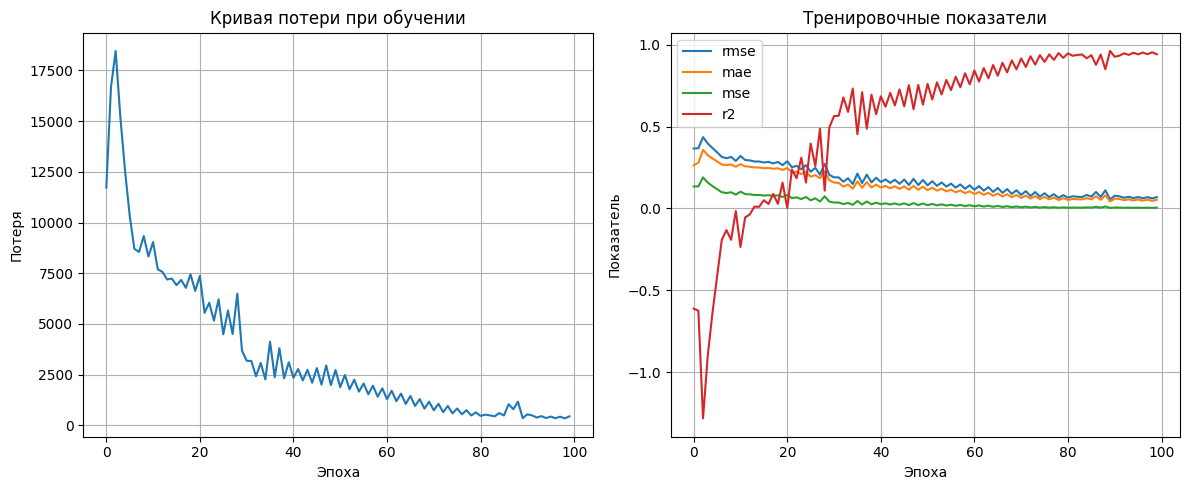

In [41]:
plot_training_history(
    train_results['train_loss'],
    titles=['Кривая потери при обучении', 'Тренировочные показатели'],
    metric_history={
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    },
)

100%|██████████| 22/22 [00:00<00:00, 650.50it/s]


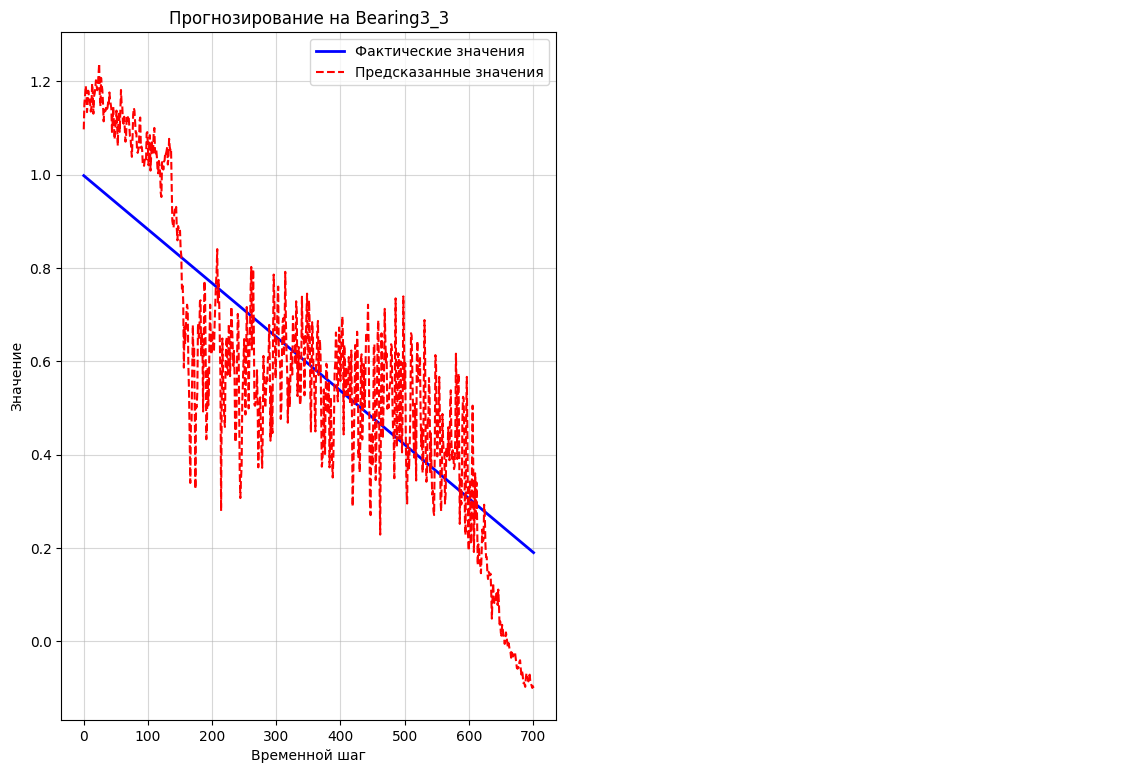

In [42]:
test_results = get_test_results(condition=3)

plot_predictions_grid(
    y_true_list=test_results['y_true_list'],
    y_pred_list=test_results['y_pred_list'],
    titles=test_results['titles'],
)

In [43]:
test_results['test_results_list']

[{'test_r2': [0.5215046568051998],
  'test_mae': [0.13691863],
  'test_mse': [0.02609339],
  'test_rmse': [0.16153449]}]